Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'returnsJSE_2Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.000705                 0.000391   
1     2006-06-02          0.017961          0.005881                 0.008007   
2     2006-06-05          0.000017         -0.003898                -0.003364   
3     2006-06-06         -0.033173         -0.016104                -0.020517   
4     2006-06-07         -0.023522         -0.025723                -0.023729   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004607          0.005424                 0.006598   
4906  2025-05-27          0.000290          0.002077                 0.000205   
4907  2025-05-28          0.000787          0.004573                 0.005829   
4908  2025-05-29          0.008886          0.004108                 0.005620   
4909  2025-05-30          0.003582          0.002694                 0.001051

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01          0.000033          0.000705                 0.000391   
1  2006-06-02          0.017961          0.005881                 0.008007   
2  2006-06-05          0.000017         -0.003898                -0.003364   
3  2006-06-06         -0.033173         -0.016104                -0.020517   
4  2006-06-07         -0.023522         -0.025723                -0.023729   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.001299                 0.000945  0.001816  0.004776  
1            0.016920                 0.014556  0.012557  0.022760  
2           -0.000357                -0.000420 -0.000836 -0.001820  
3           -0.031555                -0.029679 -0.025549 -0.034661  
4           -0.023612                -0.024112 -0.023751 -0.021412

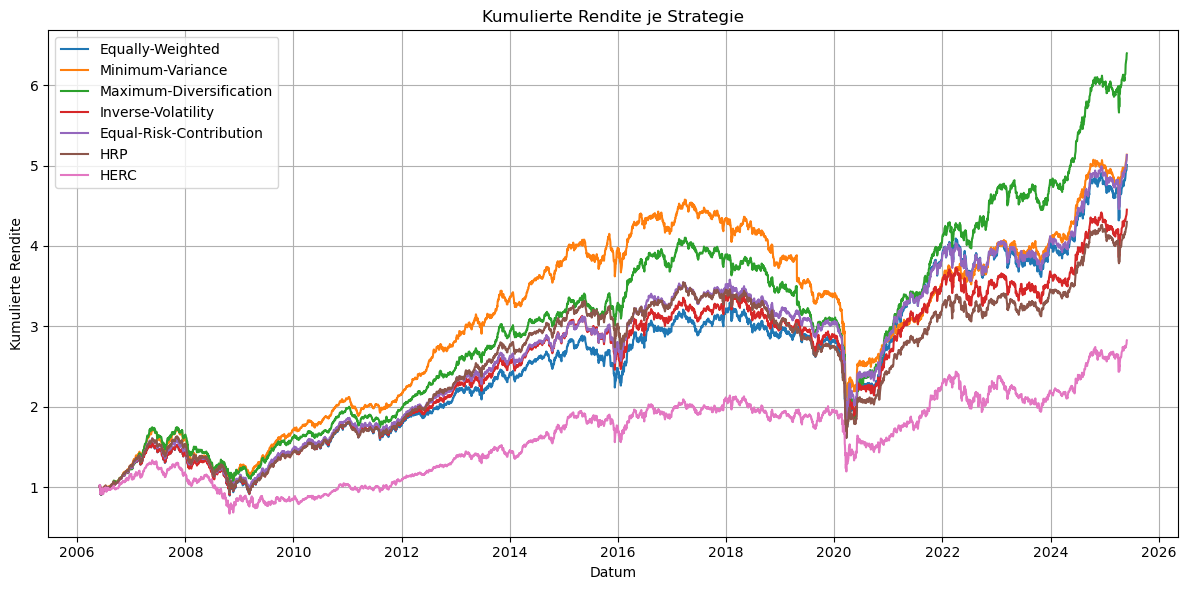

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

#Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Jahr"

jährlich_kum_returns

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Jahr                                                                
2006          0.254582          0.275013                 0.239509   
2007          0.131985          0.275638                 0.328702   
2008         -0.236476         -0.236353                -0.273588   
2009          0.340244          0.387042                 0.360859   
2010          0.234870          0.215949                 0.215682   
2011         -0.014846          0.029096                -0.001424   
2012          0.224726          0.303278                 0.253557   
2013          0.111697          0.194196                 0.178101   
2014          0.111430          0.143244                 0.091362   
2015         -0.077122          0.036821                 0.033316   
2016          0.223945          0.079105                 0.170564   
2017          0.066362          0.010829                 0.008090   
2018         -0.092786         -0.119984                -0.095428   
2019         -0.037032         -0.112368                -0.123631   
2020         -0.026426         -0.164966                -0.046320   
2021          0.425991          0.266698                 0.401308   
2022         -0.009987          0.106963                 0.129916   
2023          0.051224          0.037010                 0.037522   
2024          0.181224          0.213899                 0.251107   
2025          0.042321          0.028261                 0.059899   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Jahr                                                                   
2006            0.257446                 0.257198  0.271975  0.156762  
2007            0.130225                 0.179765  0.204004 -0.000557  
2008           -0.228606                -0.245630 -0.285805 -0.255368  
2009            0.316137                 0.326079  0.318827 -0.013577  
2010            0.249038                 0.246031  0.247762  0.221544  
2011           -0.005975                -0.003297  0.004040  0.043316  
2012            0.253988                 0.248283  0.277197  0.256134  
2013            0.142522                 0.137878  0.198050  0.067370  
2014            0.132553                 0.110161  0.123096  0.209436  
2015           -0.062255                -0.036144 -0.023127 -0.011474  
2016            0.162855                 0.202123  0.100890  0.120374  
2017            0.067918                 0.046898  0.035289  0.088600  
2018           -0.108532                -0.097763 -0.121899 -0.105238  
2019           -0.046704                -0.043022 -0.097258  0.026675  
2020           -0.087245                -0.064863 -0.113537 -0.177653  
2021            0.357853                 0.366501  0.337597  0.429800  
2022           -0.020305                 0.004681  0.011924 -0.024011  
2023            0.054847                 0.055331  0.052163 -0.012707  
2024            0.174387                 0.192162  0.217037  0.182809  
2025            0.028826                 0.044032  0.021219  0.084832

In [22]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [23]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Jahr", var_name="Strategie", value_name="Rendite")
reorganisiert.head()

Jahr         Strategie   Rendite
0  2006  Equally-Weighted  0.254582
1  2007  Equally-Weighted  0.131985
2  2008  Equally-Weighted -0.236476
3  2009  Equally-Weighted  0.340244
4  2010  Equally-Weighted  0.234870

In [24]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Jahr", y="Rendite", color="Strategie", 
             barmode="group",
             text="Rendite",
             title="Jährliche kumulierte Renditen je Strategie",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [25]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

jährliche_vola

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         18.187747         13.606294                14.362047   
2007         13.751413         11.851250                13.653385   
2008         24.591139         18.751212                19.656104   
2009         17.342555         11.543064                12.470691   
2010         11.513466          6.782918                 7.354696   
2011         11.835439          7.268171                 8.257215   
2012          7.924591          5.966175                 6.164441   
2013         10.918382          8.035263                 8.415384   
2014          8.820442          6.521871                 7.080552   
2015         13.388010          9.690020                 9.590226   
2016         14.032035          9.405338                10.122894   
2017          7.751836          5.971750                 6.606867   
2018         10.898827          8.613774                 9.136511   
2019          8.786121         10.694977                10.480853   
2020         29.318798         25.771409                28.171028   
2021         10.807078          8.340593                 8.836293   
2022         13.399600         10.207375                10.702576   
2023         10.186437          7.529997                 8.447831   
2024          9.493056          6.945862                 7.282644   
2025         14.984782         10.619085                11.663354   

      Inverse-Volatility  Equal-Risk-Contribution        HRP       HERC  
Date                                                                     
2006           17.537937                16.610896  15.379518  20.308153  
2007           13.297107                12.837480  12.027799  15.275511  
2008           23.768767                22.510975  20.968652  30.102933  
2009           16.051804                14.434047  12.853759  25.971721  
2010           10.758281                 9.232597   8.034053  10.919147  
2011           11.265350                 9.712839   8.155493  13.050890  
2012            7.422908                 6.667359   5.895099   7.797282  
2013           10.668000                 9.659569   8.724896  13.816520  
2014            8.662747                 7.611997   6.970533  11.808259  
2015           13.604123                11.618123  11.371905  16.895944  
2016           13.530831                11.281643  10.602827  15.992600  
2017            7.576566                 6.539525   6.077958   9.590063  
2018           10.967073                 9.519214   8.713440  13.062299  
2019            9.032990                 7.686824   8.286832  12.614664  
2020           28.758627                27.042189  25.847743  31.538653  
2021           10.492832                 9.348144   8.987530  14.549384  
2022           13.330783                12.054489  11.328128  20.088110  
2023           10.037063                 8.727931   7.832768  13.169765  
2024            9.369676                 8.142510   7.527472  11.602428  
2025           14.810226                13.449870  12.032680  15.538856

<Figure size 1000x600 with 0 Axes>

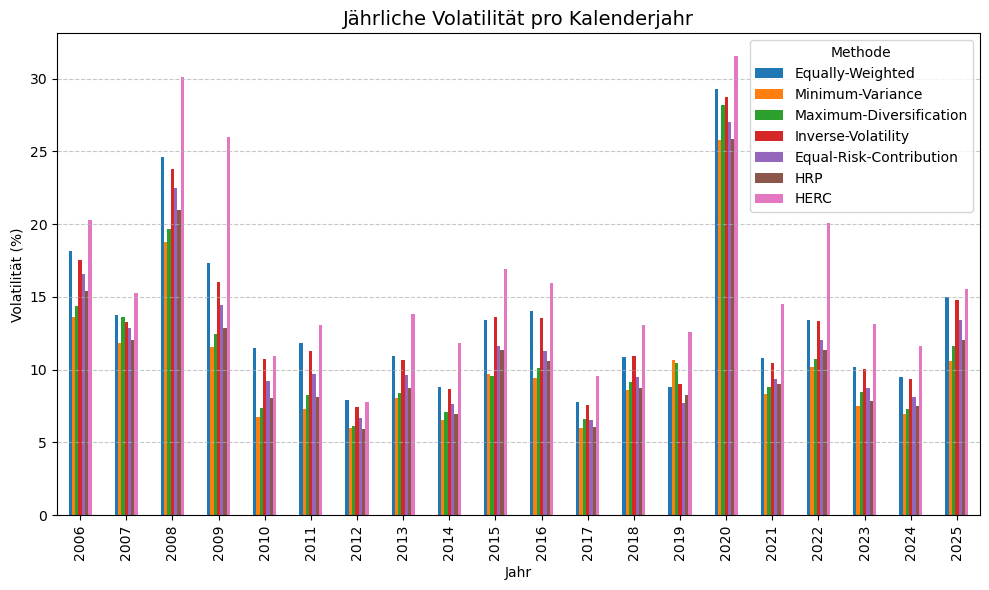

In [26]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Jährliche Volatilität pro Kalenderjahr", fontsize=14)
plt.xlabel("Jahr")
plt.ylabel("Volatilität (%)")
plt.legend(title="Methode")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
tägliche_rendite = df_SP500.groupby(df_SP500.index.year).mean()
print(tägliche_rendite)

      Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          0.001569          0.001647                 0.001464   
2007          0.000518          0.000972                 0.001139   
2008         -0.000921         -0.000971                -0.001157   
2009          0.001195          0.001295                 0.001226   
2010          0.000835          0.000759                 0.000759   
2011         -0.000030          0.000121                 0.000008   
2012          0.000789          0.001022                 0.000874   
2013          0.000429          0.000693                 0.000642   
2014          0.000420          0.000521                 0.000345   
2015         -0.000272          0.000157                 0.000144   
2016          0.000813          0.000309                 0.000624   
2017          0.000260          0.000049                 0.000040   
2018         -0.000354         -0.

In [28]:
tägliche_vola = df_SP500.groupby(df_SP500.index.year).std()
print(tägliche_vola)

      Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          0.011457          0.008571                 0.009047   
2007          0.008663          0.007466                 0.008601   
2008          0.015491          0.011812                 0.012382   
2009          0.010925          0.007271                 0.007856   
2010          0.007253          0.004273                 0.004633   
2011          0.007456          0.004579                 0.005202   
2012          0.004992          0.003758                 0.003883   
2013          0.006878          0.005062                 0.005301   
2014          0.005556          0.004108                 0.004460   
2015          0.008434          0.006104                 0.006041   
2016          0.008839          0.005925                 0.006377   
2017          0.004883          0.003762                 0.004162   
2018          0.006866          0.

#### Sharpe Ratio

In [29]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [30]:
sharpe_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.180578          3.060215                 2.576768   
2007          0.951287          2.070576                 2.106486   
2008         -0.946040         -1.307396                -1.485883   
2009          1.740044          2.833140                 2.481567   
2010          1.830737          2.823471                 2.606554   
2011         -0.063572          0.419551                 0.024501   
2012          2.515153          4.326801                 3.578604   
2013          0.992990          2.177476                 1.926768   
2014          1.202910          2.018733                 1.230008   
2015         -0.512789          0.409498                 0.378526   
2016          1.463693          0.830164                 1.555964   
2017          0.846773          0.205667                 0.151875   
2018         -0.819825         -1.408737                -1.028432   
2019         -0.376423         -1.035533                -1.178860   
2020          0.059591         -0.549758                -0.020057   
2021          3.257277          2.806114                 3.768897   
2022         -0.006352          1.025581                 1.170710   
2023          0.536419          0.515494                 0.473943   
2024          1.819887          2.854382                 3.144776   
2025          0.761869          0.704417                 1.296561   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.276563                 2.392074  2.698201  1.302874  
2007            0.967702                 1.324890  1.571287  0.072982  
2008           -0.945174                -1.107436 -1.458853 -0.803760  
2009            1.755790                 1.986587  2.172289  0.078173  
2010            2.054104                 2.351791  2.706520  1.828115  
2011            0.004628                 0.015523  0.088767  0.380695  
2012            2.987917                 3.252306  4.046232  2.869320  
2013            1.261884                 1.342190  2.047780  0.525526  
2014            1.433554                 1.366360  1.646255  1.617193  
2015           -0.388806                -0.248318 -0.141988  0.018560  
2016            1.146603                 1.635410  0.930194  0.767634  
2017            0.883353                 0.715891  0.586608  0.910913  
2018           -0.970220                -1.009932 -1.416110 -0.767795  
2019           -0.473044                -0.521421 -1.166516  0.267096  
2020           -0.163412                -0.104057 -0.322459 -0.445071  
2021            2.896189                 3.304933  3.201718  2.469744  
2022           -0.083983                 0.098159  0.159037 -0.018089  
2023            0.576846                 0.654574  0.681951 -0.030554  
2024            1.779941                 2.221592  2.674021  1.519676  
2025            0.550455                 0.862757  0.493358  1.378949

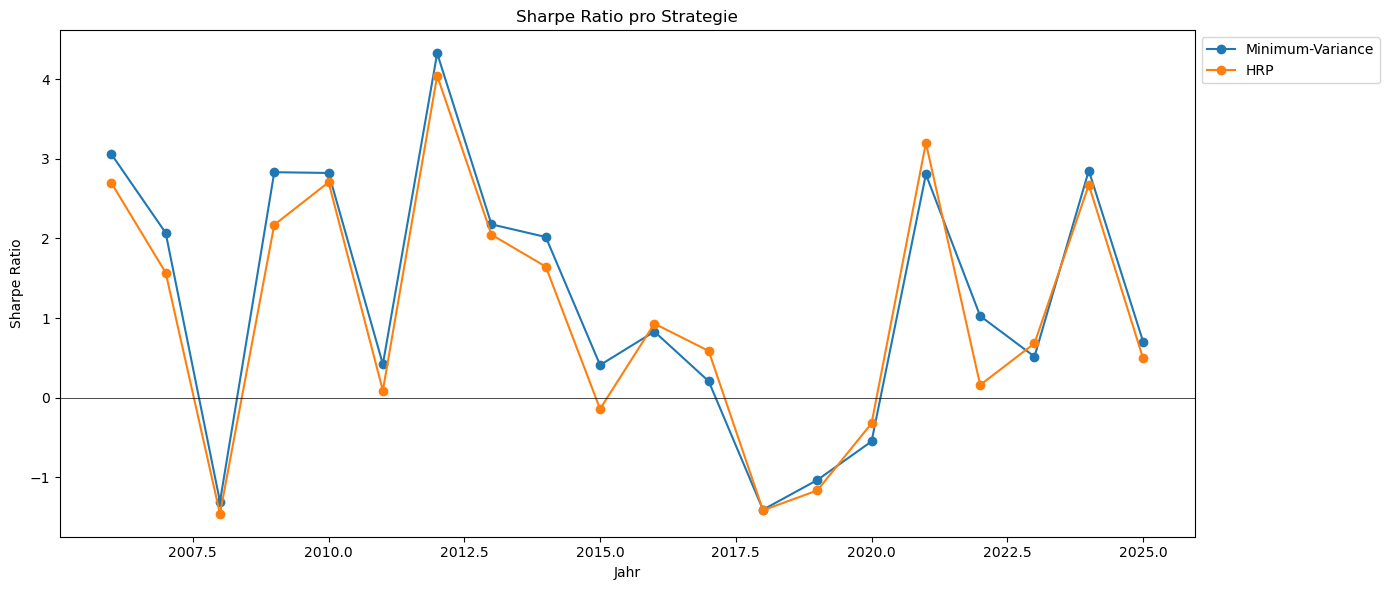

In [31]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

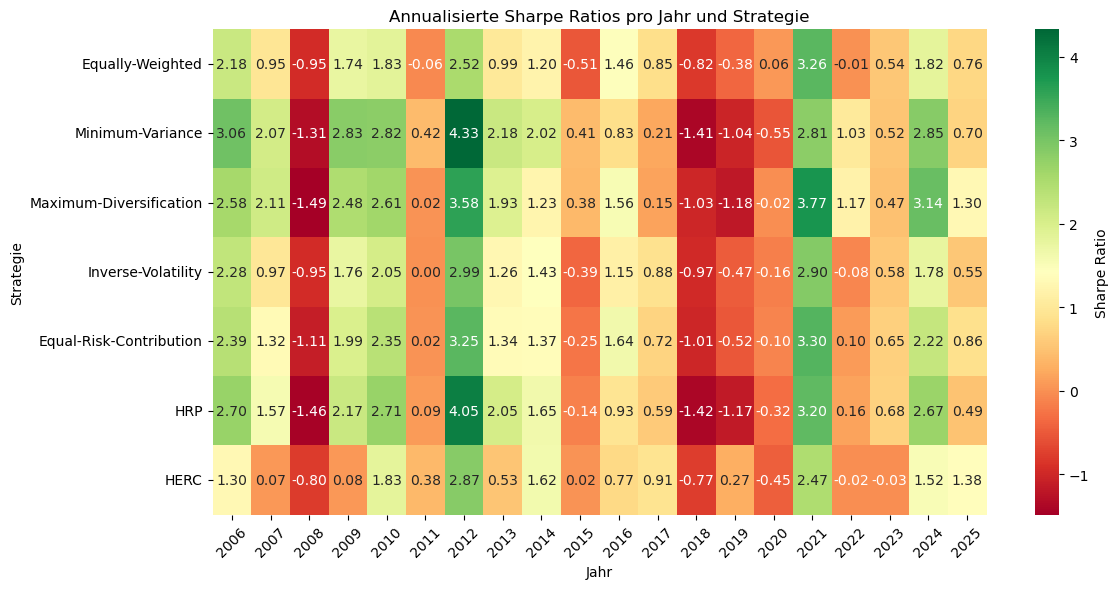

In [32]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005       
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [34]:
# Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

# Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe = df_SP500.apply(sharpe_annual)

print(gesamt_sharpe)

Equally-Weighted           0.649265
Minimum-Variance           0.806602
Maximum-Diversification    0.854032
Inverse-Volatility         0.620041
Equal-Risk-Contribution    0.725562
HRP                        0.691666
HERC                       0.394470
dtype: float64


#### Sortino

In [35]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [36]:
sortino_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.076536          4.533787                 3.728457   
2007          1.317709          2.933347                 3.088648   
2008         -1.268605         -1.719723                -1.928300   
2009          2.614755          4.598744                 3.940328   
2010          2.722787          4.285676                 3.982032   
2011         -0.085581          0.565368                 0.033250   
2012          3.776453          7.736014                 6.107075   
2013          1.351689          3.228164                 2.774948   
2014          1.771692          2.973330                 1.784781   
2015         -0.666877          0.558747                 0.529279   
2016          2.189545          1.161733                 2.310864   
2017          1.279021          0.283269                 0.211970   
2018         -1.130686         -1.839213                -1.375205   
2019         -0.520900         -1.167627                -1.412511   
2020          0.077986         -0.671141                -0.025245   
2021          5.069567          4.389139                 6.297056   
2022         -0.008725          1.415230                 1.632402   
2023          0.793219          0.743681                 0.682641   
2024          2.960350          4.598375                 5.018501   
2025          1.032163          1.033457                 1.996918   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.202870                 3.357048  3.777670  1.822885  
2007            1.341500                 1.846437  2.203533  0.096284  
2008           -1.272489                -1.472340 -1.877767 -1.085070  
2009            2.629411                 3.013008  3.315573  0.111374  
2010            3.094584                 3.545470  4.085387  2.696168  
2011            0.006259                 0.020827  0.118293  0.536353  
2012            4.619981                 5.134744  6.837582  4.489588  
2013            1.731104                 1.840424  2.899331  0.743687  
2014            2.132122                 2.001811  2.402645  2.532225  
2015           -0.504535                -0.324926 -0.183921  0.025133  
2016            1.651644                 2.428574  1.262128  1.087552  
2017            1.341182                 1.058630  0.855059  1.362600  
2018           -1.323659                -1.379905 -1.863252 -1.071825  
2019           -0.649387                -0.707785 -1.459672  0.393977  
2020           -0.210908                -0.132116 -0.402961 -0.583843  
2021            4.445984                 5.183763  5.012916  4.030767  
2022           -0.115147                 0.134129  0.216772 -0.025329  
2023            0.857468                 0.966645  0.989791 -0.045029  
2024            2.971258                 3.674187  4.517613  2.470985  
2025            0.754234                 1.186922  0.668858  1.998042

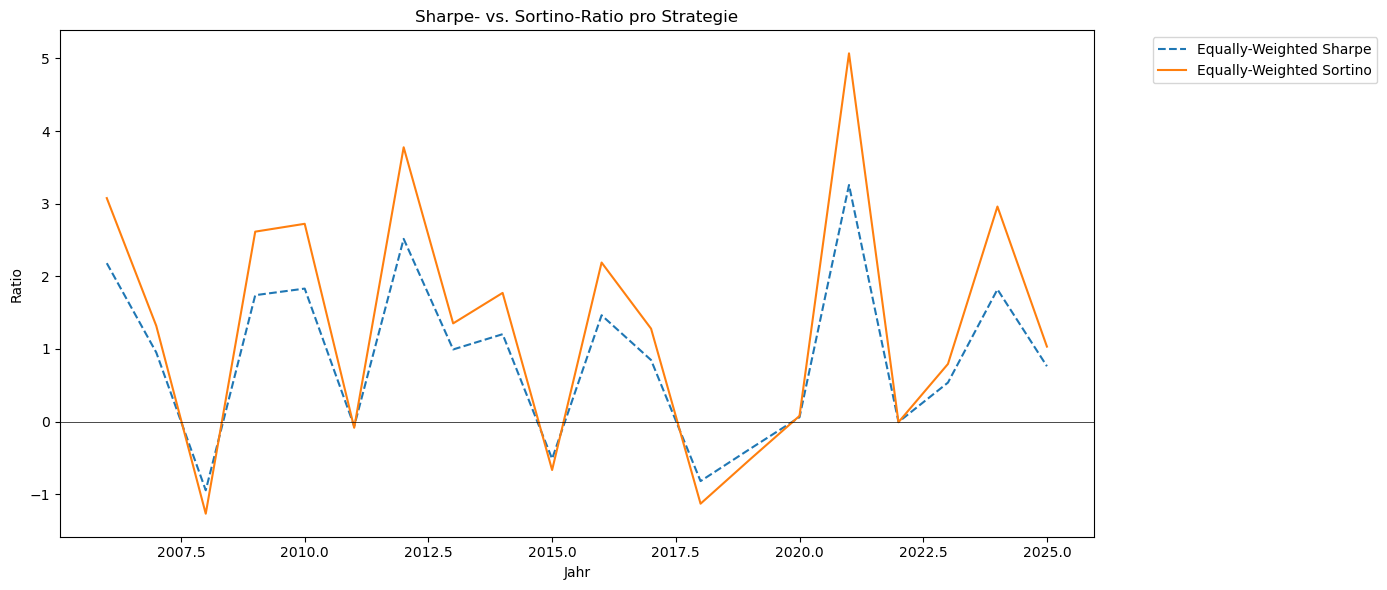

In [37]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [38]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_annual)

print(gesamt_sortino)

Equally-Weighted           0.901096
Minimum-Variance           1.082765
Maximum-Diversification    1.166668
Inverse-Volatility         0.856327
Equal-Risk-Contribution    0.995279
HRP                        0.932054
HERC                       0.551610
dtype: float64


#### Maximum Drawdown

In [39]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [40]:
max_drawdown_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.090870                -0.103311   
2007         -0.160661         -0.162816                -0.159546   
2008         -0.374764         -0.361814                -0.371579   
2009         -0.190601         -0.100930                -0.120820   
2010         -0.075729         -0.048352                -0.048084   
2011         -0.127077         -0.111722                -0.127197   
2012         -0.040825         -0.033128                -0.035358   
2013         -0.074810         -0.076699                -0.065177   
2014         -0.080826         -0.054119                -0.056955   
2015         -0.224241         -0.127527                -0.117681   
2016         -0.083576         -0.076755                -0.070881   
2017         -0.100200         -0.086116                -0.089058   
2018         -0.134913         -0.146550                -0.122763   
2019         -0.124894         -0.156043                -0.189499   
2020         -0.430288         -0.407763                -0.432154   
2021         -0.051795         -0.034504                -0.029036   
2022         -0.129816         -0.080584                -0.076112   
2023         -0.105735         -0.067384                -0.076376   
2024         -0.047226         -0.031803                -0.034688   
2025         -0.101110         -0.081411                -0.064081   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.108594                -0.107712 -0.102932 -0.112598  
2007           -0.156846                -0.159169 -0.140010 -0.157673  
2008           -0.368131                -0.378754 -0.396028 -0.425893  
2009           -0.192201                -0.164047 -0.174032 -0.176495  
2010           -0.069468                -0.059102 -0.056319 -0.112682  
2011           -0.115616                -0.110871 -0.107014 -0.098390  
2012           -0.034078                -0.029511 -0.026339 -0.026735  
2013           -0.075981                -0.069796 -0.066376 -0.101745  
2014           -0.074559                -0.069536 -0.061045 -0.084719  
2015           -0.213991                -0.185053 -0.174057 -0.199289  
2016           -0.094616                -0.082151 -0.104090 -0.101066  
2017           -0.088447                -0.076663 -0.077424 -0.091831  
2018           -0.147594                -0.133382 -0.141282 -0.149475  
2019           -0.128278                -0.116219 -0.154050 -0.122515  
2020           -0.426059                -0.414357 -0.415918 -0.388938  
2021           -0.050782                -0.046686 -0.045624 -0.090684  
2022           -0.127958                -0.116961 -0.098923 -0.206493  
2023           -0.102545                -0.088581 -0.083147 -0.187495  
2024           -0.043942                -0.043846 -0.031549 -0.058249  
2025           -0.107767                -0.091668 -0.098984 -0.093111

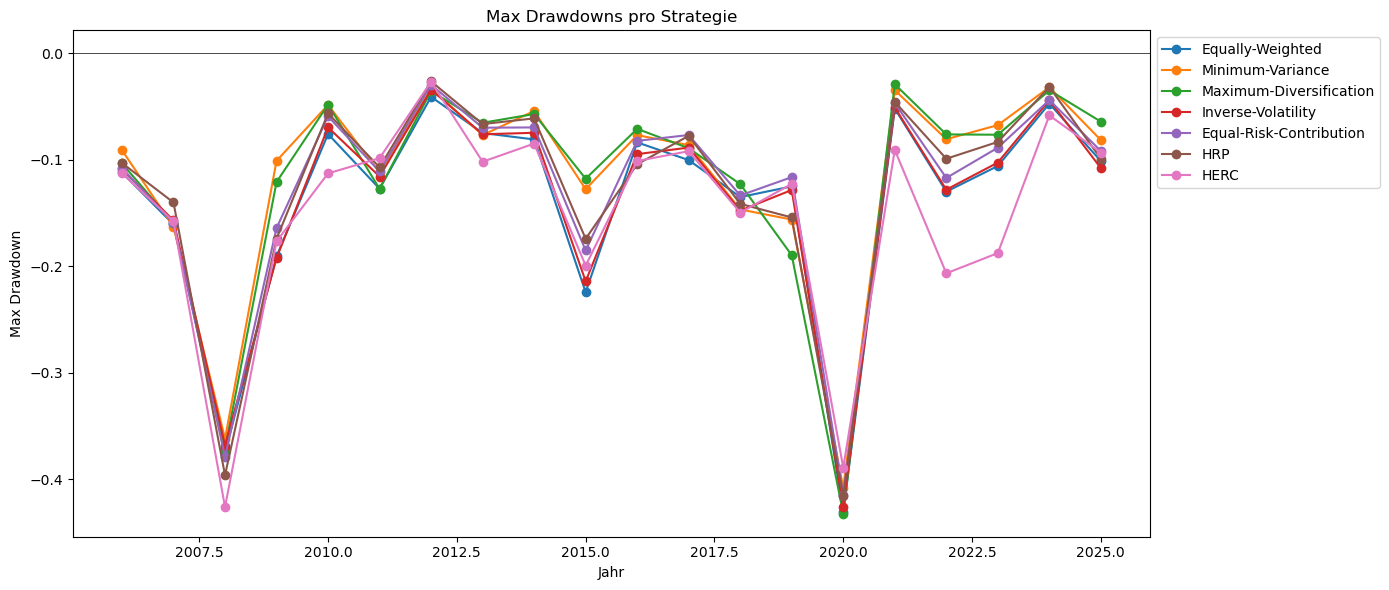

In [41]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Jahr")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdowns pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.509355
Minimum-Variance          -0.558707
Maximum-Diversification   -0.569608
Inverse-Volatility        -0.519064
Equal-Risk-Contribution   -0.498566
HRP                       -0.546192
HERC                      -0.498505
dtype: float64>

#### Calmar Ratio

In [43]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio_total))

In [44]:
calmar_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.276626          3.026434                 2.318339   
2007          0.821510          1.692940                 2.060237   
2008         -0.630998         -0.653246                -0.736285   
2009          1.785112          3.834759                 2.986743   
2010          3.101431          4.466174                 4.485545   
2011         -0.116830          0.260435                -0.011194   
2012          5.504597          9.154696                 7.171202   
2013          1.493071          2.531918                 2.732596   
2014          1.378635          2.646844                 1.604105   
2015         -0.343926          0.288731                 0.283106   
2016          2.679530          1.030616                 2.406326   
2017          0.662298          0.125754                 0.090835   
2018         -0.687746         -0.818725                -0.777333   
2019         -0.296509         -0.720112                -0.652408   
2020         -0.061416         -0.404564                -0.107184   
2021          8.224588          7.729409                13.821139   
2022         -0.076928          1.327350                 1.706896   
2023          0.484452          0.549235                 0.491277   
2024          3.837414          6.725829                 7.239019   
2025          0.418560          0.347136                 0.934745   

      Inverse-Volatility  Equal-Risk-Contribution        HRP      HERC  
Date                                                                    
2006            2.370715                 2.387843   2.642268  1.392237  
2007            0.830272                 1.129394   1.457074 -0.003534  
2008           -0.620991                -0.648521  -0.721678 -0.599605  
2009            1.644825                 1.987716   1.832000 -0.076928  
2010            3.584953                 4.162849   4.399248  1.966104  
2011           -0.051683                -0.029740   0.037749  0.440253  
2012            7.453078                 8.413296  10.524188  9.580286  
2013            1.875755                 1.975444   2.983745  0.662153  
2014            1.777812                 1.584233   2.016468  2.472109  
2015           -0.290923                -0.195320  -0.132870 -0.057577  
2016            1.721223                 2.460386   0.969256  1.191039  
2017            0.767900                 0.611741   0.455788  0.964818  
2018           -0.735346                -0.732956  -0.862804 -0.704055  
2019           -0.364084                -0.370178  -0.631339  0.217725  
2020           -0.204773                -0.156539  -0.272979 -0.456764  
2021            7.046889                 7.850264   7.399558  4.739525  
2022           -0.158682                 0.040023   0.120537 -0.116280  
2023            0.534856                 0.624644   0.627358 -0.067772  
2024            3.968586                 4.382629   6.879257  3.138420  
2025            0.267484                 0.480348   0.214363  0.911086

In [45]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.169232
Minimum-Variance           0.156796
Maximum-Diversification    0.175438
Inverse-Volatility         0.153462
Equal-Risk-Contribution    0.175629
HRP                        0.142337
HERC                       0.109847
dtype: float64>

In [46]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           7.868825
Minimum-Variance           7.402164
Maximum-Diversification    9.474679
Inverse-Volatility         6.650190
Equal-Risk-Contribution    8.287646
HRP                        6.043037
HERC                       3.662317
dtype: float64>

#### Value at Risk

In [47]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.010873                -0.010893   
2007         -0.014841         -0.011383                -0.013469   
2008         -0.026477         -0.021487                -0.021794   
2009         -0.017831         -0.010994                -0.012971   
2010         -0.011905         -0.006753                -0.007391   
2011         -0.012750         -0.008332                -0.008563   
2012         -0.008292         -0.005347                -0.005680   
2013         -0.012646         -0.008285                -0.008404   
2014         -0.008447         -0.006563                -0.007059   
2015         -0.014710         -0.007968                -0.008214   
2016         -0.013768         -0.009908                -0.010735   
2017         -0.007465         -0.006042                -0.006170   
2018         -0.010821         -0.008653                -0.009184   
2019         -0.008930         -0.007589                -0.009183   
2020         -0.024823         -0.018476                -0.019346   
2021         -0.009482         -0.008621                -0.007577   
2022         -0.014066         -0.010008                -0.010963   
2023         -0.010147         -0.007451                -0.008046   
2024         -0.008724         -0.006354                -0.006425   
2025         -0.010370         -0.010097                -0.008157   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.020093                -0.018238 -0.015780 -0.021203  
2007           -0.014584                -0.014487 -0.013768 -0.016784  
2008           -0.026118                -0.025234 -0.025883 -0.033119  
2009           -0.017044                -0.015485 -0.013483 -0.024729  
2010           -0.010222                -0.009006 -0.008002 -0.011500  
2011           -0.012218                -0.010503 -0.008455 -0.013610  
2012           -0.008309                -0.006750 -0.005232 -0.007345  
2013           -0.012554                -0.010852 -0.009030 -0.014356  
2014           -0.008841                -0.007377 -0.006969 -0.011016  
2015           -0.013757                -0.011767 -0.010776 -0.016583  
2016           -0.014020                -0.012289 -0.011626 -0.016013  
2017           -0.007393                -0.006349 -0.006363 -0.008964  
2018           -0.011198                -0.009508 -0.009240 -0.012802  
2019           -0.009123                -0.008140 -0.007618 -0.012366  
2020           -0.024926                -0.021077 -0.018763 -0.027159  
2021           -0.009280                -0.008757 -0.008345 -0.012622  
2022           -0.013841                -0.012683 -0.011410 -0.021318  
2023           -0.010247                -0.008892 -0.007551 -0.013104  
2024           -0.008375                -0.006893 -0.006700 -0.010357  
2025           -0.010440                -0.009730 -0.008857 -0.012286

In [48]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.012997
Minimum-Variance          -0.009442
Maximum-Diversification   -0.010228
Inverse-Volatility        -0.012728
Equal-Risk-Contribution   -0.011327
HRP                       -0.010632
HERC                      -0.016424
dtype: float64>

In [49]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.042966
Minimum-Variance          -0.048244
Maximum-Diversification   -0.047444
Inverse-Volatility        -0.044097
Equal-Risk-Contribution   -0.042204
HRP                       -0.045563
HERC                      -0.066068
dtype: float64>

#### Expected Shortfall

In [50]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028923         -0.020928                -0.022697   
2007         -0.021095         -0.018414                -0.020401   
2008         -0.035440         -0.028985                -0.030977   
2009         -0.022434         -0.013867                -0.015920   
2010         -0.015721         -0.009526                -0.010081   
2011         -0.017097         -0.011096                -0.012234   
2012         -0.011245         -0.007162                -0.007332   
2013         -0.016936         -0.011368                -0.012374   
2014         -0.012430         -0.009369                -0.009848   
2015         -0.020782         -0.014216                -0.013758   
2016         -0.019447         -0.013952                -0.014407   
2017         -0.009806         -0.008963                -0.009304   
2018         -0.013765         -0.012767                -0.012873   
2019         -0.012144         -0.015672                -0.015358   
2020         -0.051528         -0.047104                -0.049037   
2021         -0.013703         -0.010907                -0.010820   
2022         -0.019182         -0.015160                -0.015887   
2023         -0.012458         -0.009565                -0.010858   
2024         -0.011877         -0.008567                -0.009227   
2025         -0.023259         -0.016424                -0.016506   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.028401                -0.027202 -0.025811 -0.031534  
2007           -0.020506                -0.019999 -0.018747 -0.024484  
2008           -0.034225                -0.033278 -0.032972 -0.044756  
2009           -0.020669                -0.017849 -0.016313 -0.034599  
2010           -0.014452                -0.012427 -0.011087 -0.015501  
2011           -0.016160                -0.014164 -0.011936 -0.017981  
2012           -0.010167                -0.008816 -0.007185 -0.010021  
2013           -0.016415                -0.014908 -0.013086 -0.019467  
2014           -0.012127                -0.010807 -0.009987 -0.014575  
2015           -0.021349                -0.017980 -0.017856 -0.025171  
2016           -0.019692                -0.016575 -0.016904 -0.023443  
2017           -0.009692                -0.008561 -0.008033 -0.012751  
2018           -0.014081                -0.012421 -0.012753 -0.016710  
2019           -0.012666                -0.011143 -0.012826 -0.016463  
2020           -0.050976                -0.048872 -0.046177 -0.055552  
2021           -0.013540                -0.012028 -0.011452 -0.017927  
2022           -0.019463                -0.017583 -0.016562 -0.027780  
2023           -0.012288                -0.010721 -0.009856 -0.016544  
2024           -0.011255                -0.010024 -0.009040 -0.014658  
2025           -0.022966                -0.021069 -0.019013 -0.023552

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.021501
Minimum-Variance          -0.016632
Maximum-Diversification   -0.017677
Inverse-Volatility        -0.020934
Equal-Risk-Contribution   -0.019222
HRP                       -0.018188
HERC                      -0.025872
dtype: float64>

In [52]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.093011
Minimum-Variance          -0.089106
Maximum-Diversification   -0.093046
Inverse-Volatility        -0.091751
Equal-Risk-Contribution   -0.090086
HRP                       -0.093480
HERC                      -0.105119
dtype: float64>

In [53]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.236476
Minimum-Variance          -0.236353
Maximum-Diversification   -0.273588
Inverse-Volatility        -0.228606
Equal-Risk-Contribution   -0.245630
HRP                       -0.285805
HERC                      -0.255368
dtype: float64>

In [54]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([gesamt_sharpe, gesamt_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.649265  0.901096     -0.509355  7.868825 -0.042966   
Minimum-Variance         0.806602  1.082765     -0.558707  7.402164 -0.048244   
Maximum-Diversification  0.854032  1.166668     -0.569608  9.474679 -0.047444   
Inverse-Volatility       0.620041  0.856327     -0.519064  6.650190 -0.044097   
Equal-Risk-Contribution  0.725562  0.995279     -0.498566  8.287646 -0.042204   
HRP                      0.691666  0.932054     -0.546192  6.043037 -0.045563   
HERC                     0.394470  0.551610     -0.498505  3.662317 -0.066068   

                             ES_M  
Equally-Weighted        -0.093011  
Minimum-Variance        -0.089106  
Maximum-Diversification -0.093046  
Inverse-Volatility      -0.091751  
Equal-Risk-Contribution -0.090086  
HRP                     -0.093480  
HERC                    -0.105119  


## S&P 500 mit Ledoit-Shrinkage

In [55]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnsJSEshrinked_2Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [56]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.001005                 0.000472   
1     2006-06-02          0.017961          0.005954                 0.007823   
2     2006-06-05          0.000017         -0.003548                -0.003379   
3     2006-06-06         -0.033173         -0.017225                -0.020979   
4     2006-06-07         -0.023522         -0.026074                -0.024247   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004607          0.005678                 0.006693   
4906  2025-05-27          0.000290          0.002683                 0.000720   
4907  2025-05-28          0.000787          0.004525                 0.005536   
4908  2025-05-29          0.008886          0.005518                 0.006492   
4909  2025-05-30          0.003582          0.002942                 0.003061

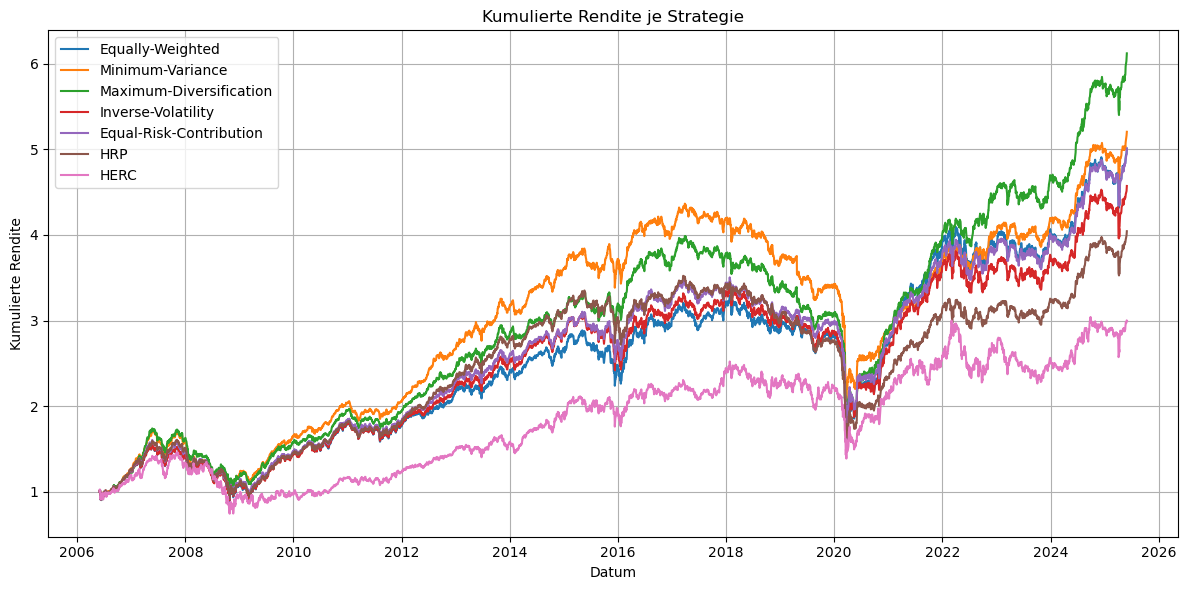

In [57]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

# Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

# Kumulierte Rendite berechnen (angenommen tägliche Returns)
# (1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

# Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [59]:
sharpe_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.180578          3.029797                 2.595964   
2007          0.951287          1.994286                 2.093885   
2008         -0.946040         -1.383393                -1.532202   
2009          1.740044          2.803577                 2.476666   
2010          1.830737          2.932906                 2.782799   
2011         -0.063572          0.180972                 0.001247   
2012          2.515153          4.335216                 3.616814   
2013          0.992990          2.148301                 1.867356   
2014          1.202910          1.999317                 1.323731   
2015         -0.512789          0.348596                 0.319552   
2016          1.463693          1.053386                 1.600289   
2017          0.846773          0.425563                 0.163848   
2018         -0.819825         -1.343545                -1.089016   
2019         -0.376423         -0.913201                -1.060543   
2020          0.059591         -0.556732                -0.096987   
2021          3.257277          3.114925                 3.854700   
2022         -0.006352          0.833661                 1.094701   
2023          0.536419          0.618282                 0.595856   
2024          1.819887          2.643061                 2.948971   
2025          0.761869          0.957693                 1.338371   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.270761                 2.389984  2.610402  1.515761  
2007            0.960428                 1.297751  1.497081  0.609409  
2008           -0.943724                -1.097208 -1.359322 -0.731494  
2009            1.747464                 1.964764  2.202997  0.203149  
2010            2.018430                 2.335096  2.632109  1.513795  
2011           -0.024249                -0.010548  0.042654  0.435189  
2012            2.939705                 3.260359  4.076619  2.167946  
2013            1.224632                 1.319035  2.003618  0.511742  
2014            1.397262                 1.356084  1.665750  1.563197  
2015           -0.418350                -0.291561 -0.170980  0.175128  
2016            1.181529                 1.507824  0.843711  0.803849  
2017            0.877847                 0.721736  0.536480  1.167159  
2018           -0.940107                -1.007173 -1.319671 -0.293749  
2019           -0.458781                -0.513576 -1.179601 -0.174246  
2020           -0.111189                -0.113118 -0.474751  0.038911  
2021            2.984513                 3.292433  3.244417  1.266621  
2022           -0.061578                 0.097037 -0.005601  0.187011  
2023            0.575118                 0.643951  0.582460 -0.117403  
2024            1.799784                 2.217501  2.547556  1.053009  
2025            0.579014                 0.835559  0.626521  0.505583

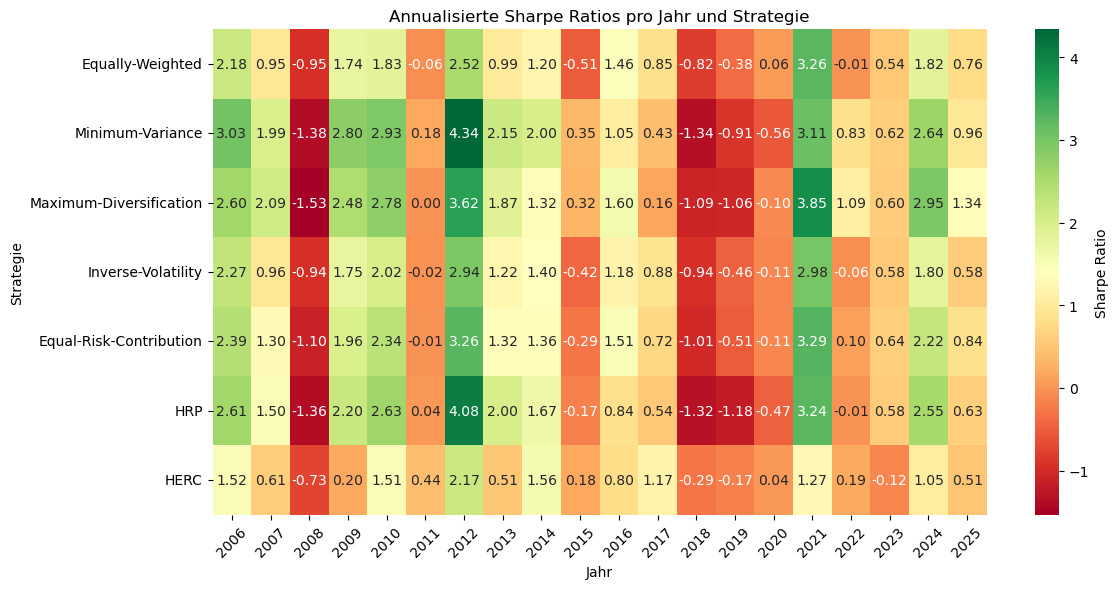

In [60]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_shrinked.T,       
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  # Strategien horizontal beschriften
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

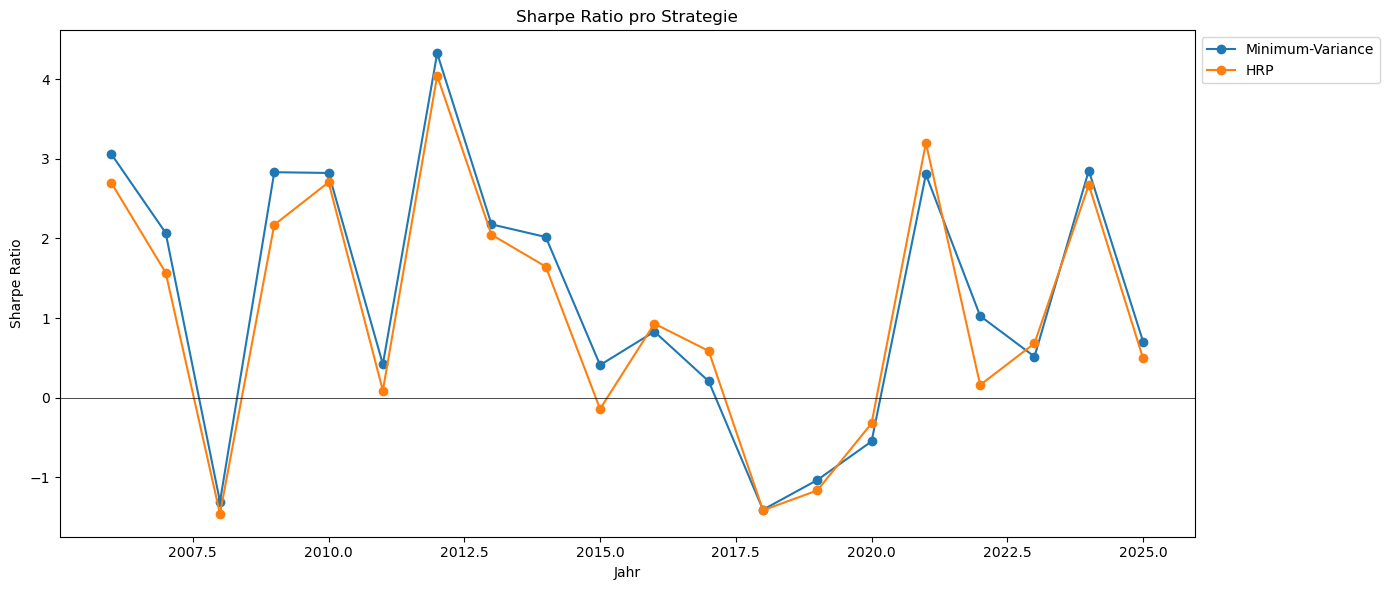

In [61]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [62]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(gesamt_sharpe_shrinked)

Equally-Weighted           0.649265
Minimum-Variance           0.830818
Maximum-Diversification    0.865249
Inverse-Volatility         0.627285
Equal-Risk-Contribution    0.711511
HRP                        0.657811
HERC                       0.401758
dtype: float64


#### Sortino Ratio

In [63]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.076536          4.455744                 3.743314   
2007          1.317709          2.808490                 3.040374   
2008         -1.268605         -1.809325                -1.981618   
2009          2.614755          4.538583                 3.916472   
2010          2.722787          4.434265                 4.252889   
2011         -0.085581          0.240984                 0.001671   
2012          3.776453          7.685558                 6.152157   
2013          1.351689          3.161994                 2.679391   
2014          1.771692          2.940706                 1.926083   
2015         -0.666877          0.472025                 0.441639   
2016          2.189545          1.488573                 2.389895   
2017          1.279021          0.593167                 0.228524   
2018         -1.130686         -1.769348                -1.456729   
2019         -0.520900         -1.084698                -1.315829   
2020          0.077986         -0.673501                -0.120640   
2021          5.069567          4.891305                 6.383998   
2022         -0.008725          1.149344                 1.526432   
2023          0.793219          0.901790                 0.862915   
2024          2.960350          4.284277                 4.677290   
2025          1.032163          1.396108                 2.004910   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.195274                 3.354241  3.669475  2.134835  
2007            1.331247                 1.809194  2.084711  0.839799  
2008           -1.269561                -1.459817 -1.765216 -1.000902  
2009            2.617696                 2.976729  3.374843  0.292378  
2010            3.035450                 3.517979  3.984291  2.225682  
2011           -0.032783                -0.014150  0.056779  0.611340  
2012            4.533805                 5.155433  6.855398  3.187465  
2013            1.677568                 1.805169  2.825240  0.714831  
2014            2.075236                 1.988716  2.435615  2.465439  
2015           -0.542578                -0.380580 -0.221290  0.240317  
2016            1.709399                 2.230222  1.146337  1.140151  
2017            1.330949                 1.075672  0.785480  1.841449  
2018           -1.285147                -1.375587 -1.758962 -0.411149  
2019           -0.629755                -0.696820 -1.519870 -0.247478  
2020           -0.144065                -0.143658 -0.587304  0.051375  
2021            4.596537                 5.153687  5.106059  1.919558  
2022           -0.084494                 0.133050 -0.007577  0.272077  
2023            0.854398                 0.952059  0.844978 -0.168950  
2024            2.991393                 3.668100  4.328178  1.686181  
2025            0.790742                 1.146023  0.857472  0.681750

In [64]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)

print(gesamt_sortino_shrinked)

Equally-Weighted           0.901096
Minimum-Variance           1.117970
Maximum-Diversification    1.179859
Inverse-Volatility         0.867224
Equal-Risk-Contribution    0.976149
HRP                        0.885884
HERC                       0.565342
dtype: float64


In [65]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.092458                -0.103207   
2007         -0.160661         -0.163423                -0.162369   
2008         -0.374764         -0.367865                -0.374798   
2009         -0.190601         -0.105838                -0.115283   
2010         -0.075729         -0.047547                -0.043749   
2011         -0.127077         -0.111585                -0.119881   
2012         -0.040825         -0.033453                -0.035181   
2013         -0.074810         -0.073538                -0.063369   
2014         -0.080826         -0.052229                -0.057975   
2015         -0.224241         -0.130859                -0.122496   
2016         -0.083576         -0.077467                -0.067118   
2017         -0.100200         -0.076847                -0.089812   
2018         -0.134913         -0.134794                -0.123395   
2019         -0.124894         -0.141456                -0.163574   
2020         -0.430288         -0.400855                -0.415560   
2021         -0.051795         -0.033910                -0.032442   
2022         -0.129816         -0.076970                -0.077034   
2023         -0.105735         -0.068577                -0.071844   
2024         -0.047226         -0.034498                -0.042362   
2025         -0.101110         -0.072605                -0.063939   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.108789                -0.107745 -0.103605 -0.112598  
2007           -0.157764                -0.159359 -0.145920 -0.183865  
2008           -0.369437                -0.378951 -0.388155 -0.448241  
2009           -0.192746                -0.164542 -0.169793 -0.187914  
2010           -0.070547                -0.059769 -0.055822 -0.112612  
2011           -0.120252                -0.114797 -0.106825 -0.083019  
2012           -0.034715                -0.029618 -0.027476 -0.034668  
2013           -0.074821                -0.067069 -0.071692 -0.100832  
2014           -0.075804                -0.070580 -0.060888 -0.085665  
2015           -0.216550                -0.189253 -0.183208 -0.166935  
2016           -0.093798                -0.083095 -0.105216 -0.092775  
2017           -0.090409                -0.076782 -0.077695 -0.100332  
2018           -0.145576                -0.135338 -0.138523 -0.169158  
2019           -0.127694                -0.116141 -0.153449 -0.176982  
2020           -0.426838                -0.419051 -0.434269 -0.374773  
2021           -0.050912                -0.048013 -0.042532 -0.118587  
2022           -0.127198                -0.118821 -0.107289 -0.240755  
2023           -0.102417                -0.090397 -0.085864 -0.191203  
2024           -0.044060                -0.043222 -0.033818 -0.061445  
2025           -0.106886                -0.094028 -0.100116 -0.118532

In [66]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.509355
Minimum-Variance          -0.529355
Maximum-Diversification   -0.545582
Inverse-Volatility        -0.517512
Equal-Risk-Contribution   -0.503182
HRP                       -0.555070
HERC                      -0.490817
dtype: float64>

#### Calmar Ratio

In [67]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.276626          2.942109                 2.327601   
2007          0.821510          1.600370                 1.907147   
2008         -0.630998         -0.669021                -0.736397   
2009          1.785112          3.505669                 3.029501   
2010          3.101431          4.771637                 5.224826   
2011         -0.116830          0.098219                -0.026016   
2012          5.504597          8.836503                 7.122168   
2013          1.493071          2.567457                 2.677657   
2014          1.378635          2.656453                 1.649592   
2015         -0.343926          0.234404                 0.221498   
2016          2.679530          1.308642                 2.551501   
2017          0.662298          0.311624                 0.097238   
2018         -0.687746         -0.840451                -0.789226   
2019         -0.296509         -0.591100                -0.605734   
2020         -0.061416         -0.396406                -0.145173   
2021          8.224588          8.652304                12.024032   
2022         -0.076928          1.097404                 1.531036   
2023          0.484452          0.642924                 0.649808   
2024          3.837414          5.559010                 5.355164   
2025          0.418560          0.551790                 0.965620   

      Inverse-Volatility  Equal-Risk-Contribution        HRP      HERC  
Date                                                                    
2006            2.366378                 2.386823   2.549065  1.682079  
2007            0.823656                 1.105729   1.328739  0.542972  
2008           -0.622278                -0.646325  -0.698281 -0.596159  
2009            1.647377                 1.962628   1.927072  0.105207  
2010            3.511982                 4.122997   4.316997  1.745010  
2011           -0.080029                -0.053772   0.000373  0.592084  
2012            7.261226                 8.459065  10.205043  6.083395  
2013            1.849469                 2.040260   2.750132  0.617248  
2014            1.708433                 1.559648   2.047192  2.493172  
2015           -0.304894                -0.219342  -0.149339  0.095646  
2016            1.807512                 2.246015   0.893531  1.303606  
2017            0.747926                 0.626416   0.416180  1.202189  
2018           -0.725454                -0.723879  -0.831896 -0.357197  
2019           -0.354541                -0.367199  -0.607601 -0.214866  
2020           -0.172023                -0.161388  -0.349513 -0.088044  
2021            7.343821                 7.648500   8.102660  1.785495  
2022           -0.136387                 0.037989  -0.070723  0.073696  
2023            0.534554                 0.614686   0.521388 -0.138918  
2024            4.016119                 4.505449   6.113021  2.226278  
2025            0.286348                 0.459349   0.290390  0.241255

In [68]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted           7.868825
Minimum-Variance           7.940431
Maximum-Diversification    9.382666
Inverse-Volatility         6.899961
Equal-Risk-Contribution    7.964724
HRP                        5.481720
HERC                       4.073216
dtype: float64>

##### Value at Risk

In [69]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.010755                -0.010970   
2007         -0.014841         -0.011694                -0.013431   
2008         -0.026477         -0.021569                -0.023031   
2009         -0.017831         -0.010774                -0.012049   
2010         -0.011905         -0.006698                -0.007422   
2011         -0.012750         -0.008307                -0.008072   
2012         -0.008292         -0.005374                -0.005815   
2013         -0.012646         -0.007594                -0.008271   
2014         -0.008447         -0.006311                -0.006754   
2015         -0.014710         -0.007936                -0.008235   
2016         -0.013768         -0.010064                -0.010538   
2017         -0.007465         -0.005663                -0.005763   
2018         -0.010821         -0.008429                -0.008681   
2019         -0.008930         -0.007398                -0.008373   
2020         -0.024823         -0.018210                -0.017405   
2021         -0.009482         -0.008316                -0.007548   
2022         -0.014066         -0.009984                -0.010835   
2023         -0.010147         -0.007132                -0.007584   
2024         -0.008724         -0.006207                -0.006304   
2025         -0.010370         -0.009355                -0.007501   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.020159                -0.018268 -0.015953 -0.021870  
2007           -0.014601                -0.014498 -0.013810 -0.018475  
2008           -0.025991                -0.025339 -0.025771 -0.035688  
2009           -0.017302                -0.015615 -0.013505 -0.026587  
2010           -0.010375                -0.009056 -0.008121 -0.012866  
2011           -0.012405                -0.010733 -0.009035 -0.013313  
2012           -0.008369                -0.006780 -0.005585 -0.009803  
2013           -0.012661                -0.011581 -0.009538 -0.013340  
2014           -0.008703                -0.007380 -0.006855 -0.012040  
2015           -0.013781                -0.011847 -0.011520 -0.017820  
2016           -0.014336                -0.012154 -0.012053 -0.014071  
2017           -0.007448                -0.006734 -0.006269 -0.009327  
2018           -0.011205                -0.009756 -0.009033 -0.016838  
2019           -0.009465                -0.008274 -0.007737 -0.014775  
2020           -0.025327                -0.021311 -0.019497 -0.031229  
2021           -0.009238                -0.008792 -0.008129 -0.015400  
2022           -0.013600                -0.012683 -0.011589 -0.020414  
2023           -0.010337                -0.008903 -0.008060 -0.014455  
2024           -0.008521                -0.006989 -0.006562 -0.011808  
2025           -0.010634                -0.009803 -0.008763 -0.011953

In [70]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.012997
Minimum-Variance          -0.009218
Maximum-Diversification   -0.009864
Inverse-Volatility        -0.012936
Equal-Risk-Contribution   -0.011491
HRP                       -0.010675
HERC                      -0.017366
dtype: float64>

In [71]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.042966
Minimum-Variance          -0.044535
Maximum-Diversification   -0.045119
Inverse-Volatility        -0.043447
Equal-Risk-Contribution   -0.042104
HRP                       -0.047261
HERC                      -0.067901
dtype: float64>

#### Expected Shortfall

In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028923         -0.021300                -0.022755   
2007         -0.021095         -0.018455                -0.019709   
2008         -0.035440         -0.029045                -0.030734   
2009         -0.022434         -0.013316                -0.015524   
2010         -0.015721         -0.009651                -0.009870   
2011         -0.017097         -0.011030                -0.011868   
2012         -0.011245         -0.006994                -0.007244   
2013         -0.016936         -0.011298                -0.012321   
2014         -0.012430         -0.009149                -0.009488   
2015         -0.020782         -0.014384                -0.013819   
2016         -0.019447         -0.014005                -0.014034   
2017         -0.009806         -0.008667                -0.009186   
2018         -0.013765         -0.012608                -0.012431   
2019         -0.012144         -0.013630                -0.013452   
2020         -0.051528         -0.045592                -0.046990   
2021         -0.013703         -0.010701                -0.010338   
2022         -0.019182         -0.015213                -0.015664   
2023         -0.012458         -0.009172                -0.010313   
2024         -0.011877         -0.008397                -0.009068   
2025         -0.023259         -0.016758                -0.016827   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.028439                -0.027217 -0.025880 -0.032231  
2007           -0.020653                -0.020029 -0.018931 -0.028215  
2008           -0.034485                -0.033405 -0.032598 -0.048338  
2009           -0.020836                -0.017917 -0.016259 -0.034177  
2010           -0.014700                -0.012559 -0.010975 -0.016567  
2011           -0.016481                -0.014573 -0.012457 -0.017258  
2012           -0.010299                -0.008876 -0.007287 -0.012499  
2013           -0.016517                -0.015108 -0.013423 -0.019116  
2014           -0.012200                -0.010840 -0.009948 -0.015622  
2015           -0.021299                -0.018153 -0.018377 -0.026009  
2016           -0.019686                -0.016547 -0.017639 -0.021994  
2017           -0.009723                -0.008624 -0.008181 -0.012541  
2018           -0.014030                -0.012474 -0.012440 -0.020882  
2019           -0.012652                -0.011157 -0.012153 -0.019626  
2020           -0.050978                -0.049074 -0.047876 -0.051230  
2021           -0.013595                -0.012065 -0.011436 -0.019837  
2022           -0.019369                -0.017657 -0.017254 -0.027183  
2023           -0.012299                -0.010925 -0.010155 -0.018717  
2024           -0.011410                -0.010148 -0.009048 -0.016126  
2025           -0.023034                -0.021445 -0.019910 -0.024492

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.021501
Minimum-Variance          -0.016358
Maximum-Diversification   -0.017139
Inverse-Volatility        -0.021040
Equal-Risk-Contribution   -0.019323
HRP                       -0.018418
HERC                      -0.026892
dtype: float64>

In [74]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.093011
Minimum-Variance          -0.085472
Maximum-Diversification   -0.090309
Inverse-Volatility        -0.091831
Equal-Risk-Contribution   -0.090493
HRP                       -0.094720
HERC                      -0.102309
dtype: float64>

In [75]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.236476
Minimum-Variance          -0.246110
Maximum-Diversification   -0.276000
Inverse-Volatility        -0.229892
Equal-Risk-Contribution   -0.244925
HRP                       -0.271042
HERC                      -0.267223
dtype: float64>

In [76]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([gesamt_sharpe_shrinked, gesamt_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.649265  0.901096     -0.509355  7.868825 -0.042966   
Minimum-Variance         0.830818  1.117970     -0.529355  7.940431 -0.044535   
Maximum-Diversification  0.865249  1.179859     -0.545582  9.382666 -0.045119   
Inverse-Volatility       0.627285  0.867224     -0.517512  6.899961 -0.043447   
Equal-Risk-Contribution  0.711511  0.976149     -0.503182  7.964724 -0.042104   
HRP                      0.657811  0.885884     -0.555070  5.481720 -0.047261   
HERC                     0.401758  0.565342     -0.490817  4.073216 -0.067901   

                             ES_M  
Equally-Weighted        -0.093011  
Minimum-Variance        -0.085472  
Maximum-Diversification -0.090309  
Inverse-Volatility      -0.091831  
Equal-Risk-Contribution -0.090493  
HRP                     -0.094720  
HERC                    -0.102309  


## 2-Jahre Trainingsfenster S&P500

In [77]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'returnsJSE_3Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [78]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.000705                 0.000391   
1     2006-06-02          0.017961          0.005881                 0.008007   
2     2006-06-05          0.000017         -0.003898                -0.003364   
3     2006-06-06         -0.033173         -0.016104                -0.020517   
4     2006-06-07         -0.023522         -0.025723                -0.023729   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004631          0.007019                 0.007248   
4906  2025-05-27          0.000343          0.002567                 0.000236   
4907  2025-05-28          0.000781          0.004594                 0.007441   
4908  2025-05-29          0.009012          0.004622                 0.005125   
4909  2025-05-30          0.003283          0.001526                -0.000358

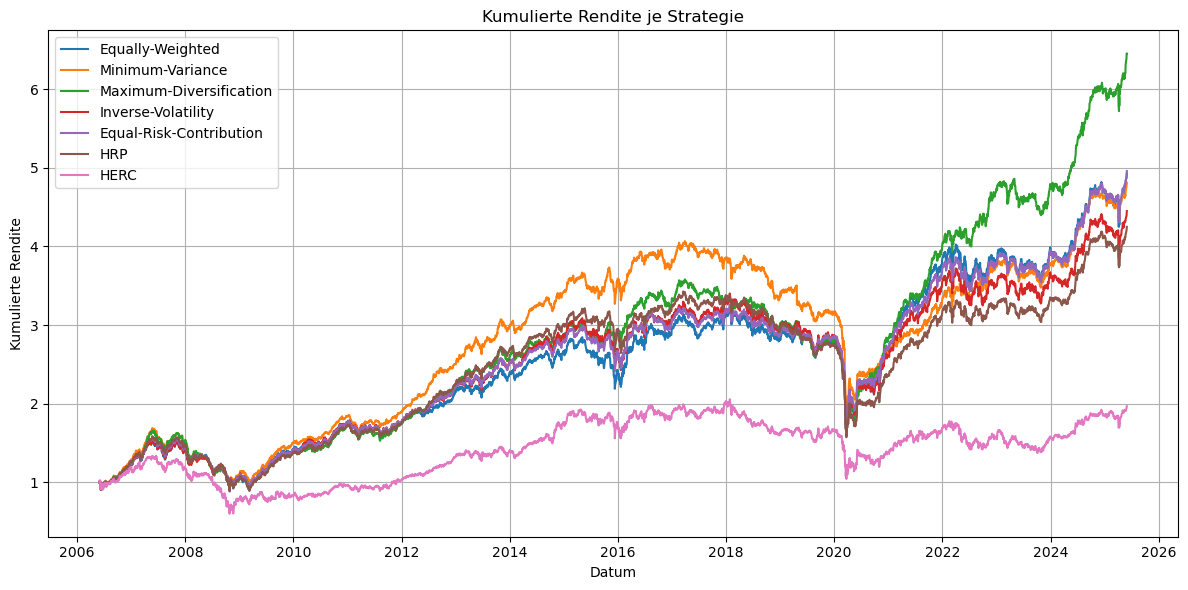

In [79]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.172681          3.182845                 2.549891   
2007          0.911357          1.491048                 1.652329   
2008         -1.000773         -1.600147                -1.944896   
2009          1.753632          2.631886                 2.425213   
2010          1.837670          2.647269                 2.490046   
2011         -0.011946          0.477598                 0.270129   
2012          2.541658          4.584596                 3.687772   
2013          1.004423          2.184566                 1.959703   
2014          1.229359          2.039320                 1.427096   
2015         -0.641158          0.505792                 0.301865   
2016          1.465071          0.714783                 1.252015   
2017          0.868485          0.116150                 0.090514   
2018         -0.834164         -1.379796                -1.107029   
2019         -0.311285         -0.676029                -0.677682   
2020          0.060772         -0.544861                 0.183150   
2021          3.243379          2.536123                 3.777563   
2022         -0.016102          1.164460                 1.519275   
2023          0.515737          0.225928                 0.257726   
2024          1.840139          2.891533                 3.053179   
2025          0.799823          0.888256                 1.642600   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.268329                 2.386391  2.661614  1.541656  
2007            0.938034                 1.175954  1.358967 -0.007964  
2008           -0.990232                -1.196278 -1.513166 -0.989688  
2009            1.749249                 1.955986  2.191651  0.314027  
2010            2.050990                 2.315732  2.698680  1.215537  
2011            0.038197                 0.074803  0.217572  0.488676  
2012            3.022206                 3.301145  4.166445  2.849549  
2013            1.271761                 1.357021  2.056244  0.483094  
2014            1.441305                 1.395566  1.587179  1.888738  
2015           -0.442205                -0.372778 -0.125395  0.023892  
2016            1.137192                 1.258481  0.918827  0.551288  
2017            0.892638                 0.668713  0.643322  0.836480  
2018           -0.952313                -0.912856 -1.383185 -1.633124  
2019           -0.420967                -0.295465 -0.921271  0.208769  
2020           -0.143082                -0.034404 -0.395930 -0.440781  
2021            2.904799                 3.350169  3.269889  1.445191  
2022           -0.067891                 0.158094  0.187170 -0.349178  
2023            0.558910                 0.606095  0.526702  0.197311  
2024            1.798876                 2.260684  2.871723  1.573259  
2025            0.567488                 0.947687  0.607031  1.030288

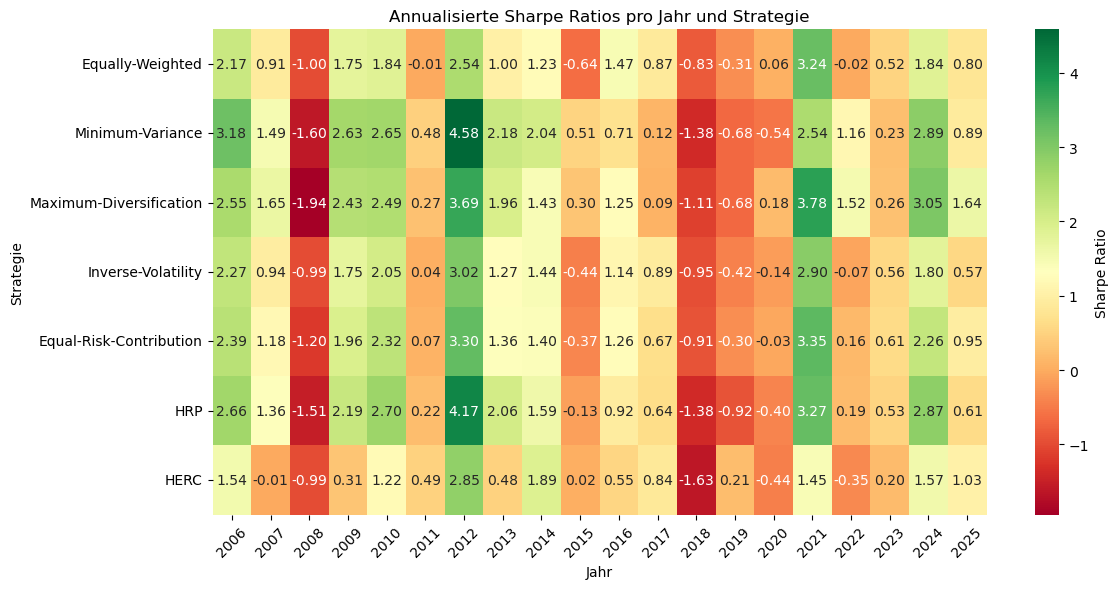

In [81]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

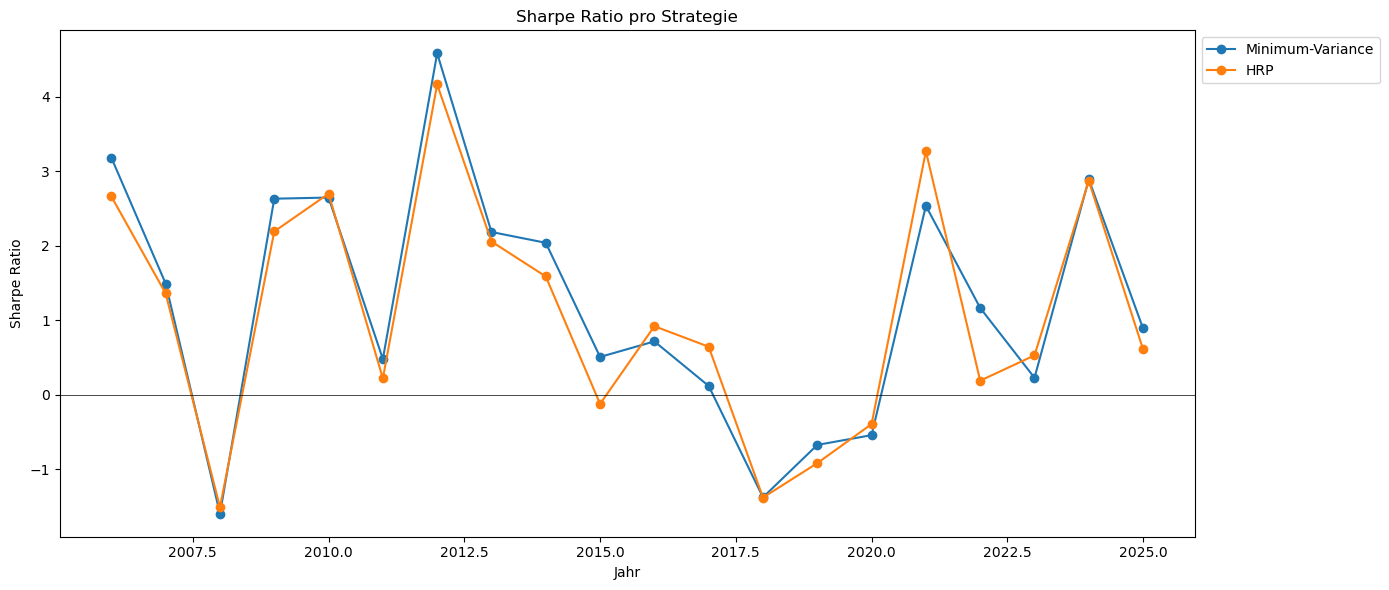

In [82]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [83]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           0.644102
Minimum-Variance           0.786870
Maximum-Diversification    0.873533
Inverse-Volatility         0.618771
Equal-Risk-Contribution    0.710345
HRP                        0.681437
HERC                       0.287245
dtype: float64


In [84]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.064016          4.714848                 3.667905   
2007          1.254721          2.056528                 2.307156   
2008         -1.336816         -2.052295                -2.446558   
2009          2.638123          4.203534                 3.769385   
2010          2.729618          3.967051                 3.809702   
2011         -0.016143          0.637770                 0.363168   
2012          3.823565          8.716914                 6.402066   
2013          1.367001          3.200333                 2.812768   
2014          1.812769          3.001834                 2.062714   
2015         -0.830521          0.689913                 0.418374   
2016          2.198295          0.989839                 1.814990   
2017          1.313013          0.159473                 0.126310   
2018         -1.149650         -1.808799                -1.486052   
2019         -0.433581         -0.783951                -0.844223   
2020          0.079617         -0.674788                 0.234724   
2021          5.017061          3.889485                 6.440649   
2022         -0.022092          1.629577                 2.174859   
2023          0.761789          0.316571                 0.362769   
2024          2.997002          4.692496                 4.904809   
2025          1.087534          1.275338                 2.502472   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.191933                 3.348682  3.727726  2.178971  
2007            1.291802                 1.614713  1.867064 -0.010577  
2008           -1.329424                -1.580663 -1.948629 -1.332081  
2009            2.616207                 2.958434  3.344203  0.473025  
2010            3.085441                 3.483934  4.060932  1.739725  
2011            0.051763                 0.100673  0.291491  0.689422  
2012            4.684456                 5.247883  7.189993  4.459344  
2013            1.743876                 1.859194  2.905370  0.667744  
2014            2.144355                 2.035468  2.293089  2.996834  
2015           -0.573239                -0.485260 -0.162437  0.032433  
2016            1.642314                 1.841197  1.256604  0.775186  
2017            1.357659                 0.989052  0.945960  1.219532  
2018           -1.301028                -1.253281 -1.816358 -2.157233  
2019           -0.580053                -0.404502 -1.161647  0.306027  
2020           -0.186055                -0.044195 -0.499031 -0.576996  
2021            4.432894                 5.221560  5.067943  2.115795  
2022           -0.093074                 0.216519  0.253098 -0.478219  
2023            0.829513                 0.891662  0.754905  0.284964  
2024            3.007845                 3.750005  4.904728  2.758320  
2025            0.778961                 1.316608  0.825935  1.481223

In [85]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           0.893591
Minimum-Variance           1.061188
Maximum-Diversification    1.196892
Inverse-Volatility         0.855421
Equal-Risk-Contribution    0.975131
HRP                        0.918258
HERC                       0.400037
dtype: float64


In [86]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.090870                -0.103311   
2007         -0.159674         -0.159751                -0.154709   
2008         -0.377122         -0.377460                -0.404522   
2009         -0.190988         -0.118431                -0.120475   
2010         -0.075705         -0.044395                -0.042232   
2011         -0.125871         -0.107052                -0.117001   
2012         -0.040825         -0.025051                -0.028461   
2013         -0.074547         -0.076118                -0.063046   
2014         -0.080819         -0.052877                -0.058437   
2015         -0.230653         -0.124224                -0.114420   
2016         -0.083576         -0.076755                -0.071733   
2017         -0.100200         -0.086632                -0.098607   
2018         -0.136383         -0.146677                -0.127288   
2019         -0.123416         -0.131109                -0.147960   
2020         -0.429823         -0.394214                -0.414851   
2021         -0.052836         -0.036769                -0.030375   
2022         -0.129398         -0.068145                -0.062771   
2023         -0.107711         -0.093160                -0.094801   
2024         -0.048191         -0.033534                -0.032642   
2025         -0.099655         -0.071876                -0.057021   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.108594                -0.107712 -0.102932 -0.112598  
2007           -0.155114                -0.158486 -0.140793 -0.154583  
2008           -0.369943                -0.385828 -0.395901 -0.490442  
2009           -0.194382                -0.166289 -0.170033 -0.142051  
2010           -0.068993                -0.057421 -0.053527 -0.114598  
2011           -0.114410                -0.108971 -0.099867 -0.090837  
2012           -0.033883                -0.030113 -0.025064 -0.030398  
2013           -0.075856                -0.069993 -0.068527 -0.097764  
2014           -0.074869                -0.070917 -0.060532 -0.074429  
2015           -0.216368                -0.191828 -0.170326 -0.189293  
2016           -0.094616                -0.082151 -0.104090 -0.101066  
2017           -0.087723                -0.076881 -0.067207 -0.092215  
2018           -0.146202                -0.125225 -0.140372 -0.222476  
2019           -0.126621                -0.101928 -0.141171 -0.109256  
2020           -0.423531                -0.410196 -0.428581 -0.374793  
2021           -0.051778                -0.046686 -0.045624 -0.090684  
2022           -0.126500                -0.112189 -0.095782 -0.202501  
2023           -0.104247                -0.093505 -0.090106 -0.173290  
2024           -0.044248                -0.044177 -0.029513 -0.042783  
2025           -0.107202                -0.087911 -0.095214 -0.111330

In [87]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.507104
Minimum-Variance          -0.527302
Maximum-Diversification   -0.537657
Inverse-Volatility        -0.513886
Equal-Risk-Contribution   -0.481158
HRP                       -0.540485
HERC                      -0.549494
dtype: float64>

In [88]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.270410          3.153798                 2.294125   
2007          0.777797          1.200325                 1.560246   
2008         -0.649906         -0.727541                -0.805181   
2009          1.794685          3.055756                 3.013401   
2010          3.121171          4.763723                 5.060815   
2011         -0.070445          0.309034                 0.168019   
2012          5.570770         12.758019                 9.196865   
2013          1.517990          2.588775                 2.869201   
2014          1.412138          2.732840                 1.796343   
2015         -0.405626          0.382475                 0.225092   
2016          2.694828          0.877278                 1.850496   
2017          0.681742          0.063331                 0.040192   
2018         -0.691639         -0.809383                -0.791335   
2019         -0.257316         -0.543647                -0.481834   
2020         -0.060478         -0.388437                 0.031265   
2021          8.027979          6.772616                13.818787   
2022         -0.087409          1.756121                 2.670666   
2023          0.454546          0.158947                 0.199201   
2024          3.799022          6.663362                 7.697796   
2025          0.446663          0.514941                 1.328268   

      Inverse-Volatility  Equal-Risk-Contribution        HRP      HERC  
Date                                                                    
2006            2.364732                 2.383268   2.606350  1.701518  
2007            0.798099                 0.985481   1.200847 -0.099732  
2008           -0.638366                -0.673903  -0.739352 -0.659351  
2009            1.616773                 1.931465   1.875561  0.344409  
2010            3.608309                 4.235963   4.588439  1.428231  
2011           -0.019222                 0.023653   0.150964  0.654204  
2012            7.590465                 8.357160  11.391206  9.512765  
2013            1.897750                 1.990991   2.904558  0.608561  
2014            1.784906                 1.588650   1.967060  3.385894  
2015           -0.321077                -0.266558  -0.124919 -0.057625  
2016            1.716919                 1.849423   0.975233  0.824840  
2017            0.786808                 0.570439   0.590155  0.883240  
2018           -0.732389                -0.712882  -0.861768 -0.888783  
2019           -0.333515                -0.254630  -0.551984  0.165989  
2020           -0.195880                -0.114513  -0.318831 -0.454413  
2021            6.946788                 7.969306   7.514302  2.469968  
2022           -0.143311                 0.107955   0.158315 -0.383385  
2023            0.507123                 0.545418   0.438523  0.104084  
2024            3.992502                 4.421883   7.929171  3.959108  
2025            0.278727                 0.556191   0.284022  0.565997

In [89]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted            7.749048
Minimum-Variance            7.223095
Maximum-Diversification    10.140624
Inverse-Volatility          6.713754
Equal-Risk-Contribution     8.228260
HRP                         6.011727
HERC                        1.764581
dtype: float64>

In [90]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.010844                -0.011686   
2007         -0.014825         -0.011595                -0.013333   
2008         -0.026470         -0.023662                -0.022348   
2009         -0.017581         -0.010915                -0.011377   
2010         -0.011813         -0.007408                -0.007466   
2011         -0.012912         -0.007946                -0.009082   
2012         -0.008335         -0.004758                -0.005252   
2013         -0.012646         -0.008285                -0.008647   
2014         -0.008447         -0.006175                -0.006827   
2015         -0.015140         -0.007859                -0.009093   
2016         -0.013721         -0.009908                -0.010462   
2017         -0.007297         -0.006445                -0.007248   
2018         -0.010606         -0.008864                -0.008288   
2019         -0.008850         -0.008205                -0.008718   
2020         -0.024322         -0.018712                -0.019144   
2021         -0.009399         -0.008614                -0.008099   
2022         -0.014066         -0.010028                -0.010923   
2023         -0.010136         -0.008470                -0.008832   
2024         -0.008724         -0.006478                -0.006435   
2025         -0.010363         -0.011745                -0.008197   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.020153                -0.018271 -0.015792 -0.021236  
2007           -0.014837                -0.014451 -0.013384 -0.019696  
2008           -0.026420                -0.025616 -0.025849 -0.033923  
2009           -0.017044                -0.015296 -0.013448 -0.022722  
2010           -0.010041                -0.009258 -0.008045 -0.012644  
2011           -0.012327                -0.010577 -0.008515 -0.014339  
2012           -0.008299                -0.006767 -0.005268 -0.007934  
2013           -0.012554                -0.010716 -0.009709 -0.014887  
2014           -0.008841                -0.007356 -0.006969 -0.011412  
2015           -0.014164                -0.012423 -0.011347 -0.016513  
2016           -0.014020                -0.012023 -0.011858 -0.018168  
2017           -0.007387                -0.006481 -0.006148 -0.009196  
2018           -0.011222                -0.009387 -0.009368 -0.012609  
2019           -0.009412                -0.008134 -0.007913 -0.011528  
2020           -0.024913                -0.020658 -0.019846 -0.029129  
2021           -0.009232                -0.008344 -0.007812 -0.013258  
2022           -0.013868                -0.012648 -0.011278 -0.019826  
2023           -0.010196                -0.009005 -0.007812 -0.014135  
2024           -0.008330                -0.006663 -0.006325 -0.008177  
2025           -0.010157                -0.009063 -0.009187 -0.011911

In [91]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.013134
Minimum-Variance          -0.009817
Maximum-Diversification   -0.010320
Inverse-Volatility        -0.012830
Equal-Risk-Contribution   -0.011432
HRP                       -0.010665
HERC                      -0.016584
dtype: float64>

In [92]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.042664
Minimum-Variance          -0.043983
Maximum-Diversification   -0.045093
Inverse-Volatility        -0.043801
Equal-Risk-Contribution   -0.041146
HRP                       -0.044590
HERC                      -0.063275
dtype: float64>

In [93]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028949         -0.020928                -0.022975   
2007         -0.021062         -0.019491                -0.021094   
2008         -0.035045         -0.030235                -0.030000   
2009         -0.022245         -0.014333                -0.016739   
2010         -0.015736         -0.010225                -0.010452   
2011         -0.017402         -0.011023                -0.012460   
2012         -0.011270         -0.006414                -0.007247   
2013         -0.016928         -0.011722                -0.012525   
2014         -0.012386         -0.009298                -0.009546   
2015         -0.020828         -0.014493                -0.014144   
2016         -0.019512         -0.014125                -0.014544   
2017         -0.009765         -0.009538                -0.009784   
2018         -0.013804         -0.012880                -0.012715   
2019         -0.012207         -0.015047                -0.014748   
2020         -0.051343         -0.042196                -0.044151   
2021         -0.013765         -0.011683                -0.011060   
2022         -0.019328         -0.014374                -0.014966   
2023         -0.012535         -0.010583                -0.011504   
2024         -0.011932         -0.008681                -0.009549   
2025         -0.023034         -0.017426                -0.016656   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.028401                -0.027211 -0.025811 -0.031534  
2007           -0.020354                -0.020316 -0.018823 -0.025333  
2008           -0.033862                -0.032992 -0.032237 -0.050829  
2009           -0.020732                -0.018085 -0.016129 -0.026929  
2010           -0.014446                -0.012530 -0.011007 -0.017911  
2011           -0.016433                -0.014613 -0.012082 -0.018232  
2012           -0.010183                -0.008806 -0.007095 -0.011466  
2013           -0.016444                -0.014931 -0.013224 -0.019660  
2014           -0.012111                -0.010797 -0.010056 -0.014803  
2015           -0.021447                -0.018378 -0.017958 -0.025334  
2016           -0.019740                -0.016723 -0.017154 -0.024677  
2017           -0.009670                -0.008578 -0.008015 -0.013623  
2018           -0.014099                -0.012431 -0.012860 -0.017874  
2019           -0.012650                -0.011002 -0.012721 -0.014714  
2020           -0.050849                -0.048202 -0.047199 -0.052769  
2021           -0.013620                -0.012039 -0.011569 -0.020090  
2022           -0.019538                -0.017492 -0.016845 -0.025421  
2023           -0.012350                -0.010878 -0.010077 -0.018066  
2024           -0.011310                -0.010010 -0.008789 -0.011092  
2025           -0.022930                -0.020781 -0.019361 -0.023894

In [94]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.021519
Minimum-Variance          -0.016717
Maximum-Diversification   -0.017619
Inverse-Volatility        -0.021026
Equal-Risk-Contribution   -0.019338
HRP                       -0.018408
HERC                      -0.026130
dtype: float64>

In [95]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.092950
Minimum-Variance          -0.087863
Maximum-Diversification   -0.091461
Inverse-Volatility        -0.091730
Equal-Risk-Contribution   -0.090419
HRP                       -0.093979
HERC                      -0.102881
dtype: float64>

In [96]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.245094
Minimum-Variance          -0.274617
Maximum-Diversification   -0.325713
Inverse-Volatility        -0.236159
Equal-Risk-Contribution   -0.260010
HRP                       -0.292710
HERC                      -0.323374
dtype: float64>

In [97]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([gesamt_sharpe_2jahre, gesamt_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown     Calmar  \
Equally-Weighted         0.644102  0.893591     -0.507104   7.749048   
Minimum-Variance         0.786870  1.061188     -0.527302   7.223095   
Maximum-Diversification  0.873533  1.196892     -0.537657  10.140624   
Inverse-Volatility       0.618771  0.855421     -0.513886   6.713754   
Equal-Risk-Contribution  0.710345  0.975131     -0.481158   8.228260   
HRP                      0.681437  0.918258     -0.540485   6.011727   
HERC                     0.287245  0.400037     -0.549494   1.764581   

                            Var_M      ES_M  
Equally-Weighted        -0.042664 -0.092950  
Minimum-Variance        -0.043983 -0.087863  
Maximum-Diversification -0.045093 -0.091461  
Inverse-Volatility      -0.043801 -0.091730  
Equal-Risk-Contribution -0.041146 -0.090419  
HRP                     -0.044590 -0.093979  
HERC                    -0.063275 -0.102881  


## S&P 500 2Jahre Shrinked

In [98]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnsJSEshrinked_3Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [99]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.001005                 0.000472   
1     2006-06-02          0.017961          0.005954                 0.007823   
2     2006-06-05          0.000017         -0.003548                -0.003379   
3     2006-06-06         -0.033173         -0.017225                -0.020979   
4     2006-06-07         -0.023522         -0.026074                -0.024247   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004631          0.006515                 0.007158   
4906  2025-05-27          0.000343          0.003085                 0.000922   
4907  2025-05-28          0.000781          0.004832                 0.006721   
4908  2025-05-29          0.009012          0.005915                 0.006157   
4909  2025-05-30          0.003283          0.001684                 0.001187

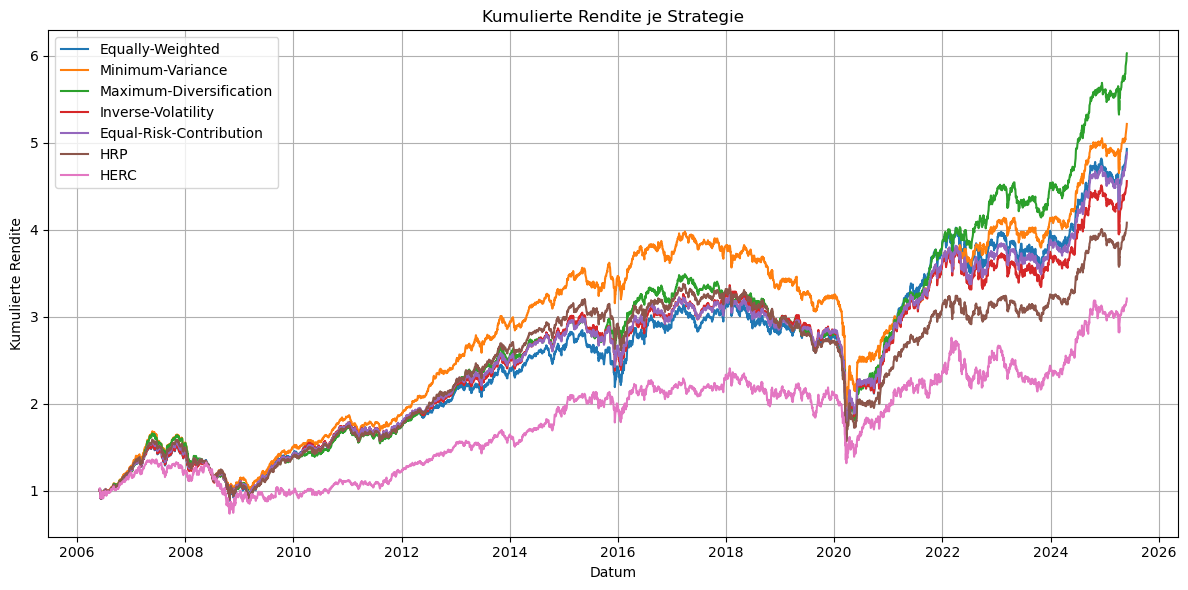

In [100]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.172681          3.143455                 2.591151   
2007          0.911357          1.643884                 1.704737   
2008         -1.000773         -1.641200                -1.928752   
2009          1.753632          2.642929                 2.424267   
2010          1.837670          2.733703                 2.589363   
2011         -0.011946          0.263274                 0.168242   
2012          2.541658          4.538954                 3.716254   
2013          1.004423          2.183676                 1.873528   
2014          1.229359          1.983207                 1.519525   
2015         -0.641158          0.441090                 0.202882   
2016          1.465071          0.856428                 1.333086   
2017          0.868485          0.319644                 0.158368   
2018         -0.834164         -1.324312                -1.113105   
2019         -0.311285         -0.502042                -0.557269   
2020          0.060772         -0.408680                 0.064215   
2021          3.243379          3.026334                 3.827615   
2022         -0.016102          1.023852                 1.326526   
2023          0.515737          0.418493                 0.404392   
2024          1.840139          2.752334                 3.003970   
2025          0.799823          1.093647                 1.606508   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.262437                 2.384167  2.628162  1.642920  
2007            0.938396                 1.171533  1.406340  0.094093  
2008           -0.990085                -1.186179 -1.460404 -0.499454  
2009            1.742771                 1.943284  2.169879  0.221853  
2010            2.018235                 2.300384  2.576519  0.933221  
2011            0.017579                 0.099079  0.117926  0.711887  
2012            2.941600                 3.280318  4.011647  2.451863  
2013            1.234972                 1.330250  1.995975  0.650265  
2014            1.408231                 1.391121  1.623611  1.427452  
2015           -0.476133                -0.386785 -0.157709  0.139572  
2016            1.171931                 1.261110  0.850199  0.688747  
2017            0.888089                 0.659803  0.603005  0.761307  
2018           -0.926041                -0.908392 -1.294317 -0.452763  
2019           -0.405488                -0.345563 -0.983648 -0.039930  
2020           -0.094707                -0.062462 -0.394888 -0.070848  
2021            2.985840                 3.317818  3.203424  1.206609  
2022           -0.051864                 0.125429  0.046314  0.367860  
2023            0.556297                 0.607207  0.562190 -0.142510  
2024            1.820638                 2.251712  2.662325  1.763505  
2025            0.600647                 0.938492  0.641145  0.923972

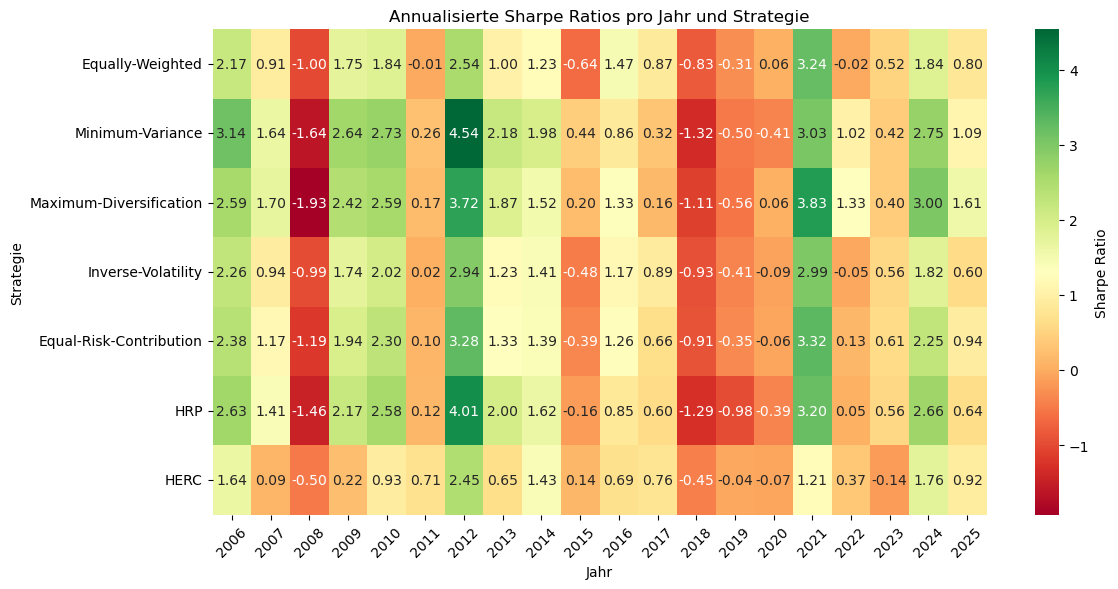

In [102]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre_shrinked.T,        
            annot=True,                 
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

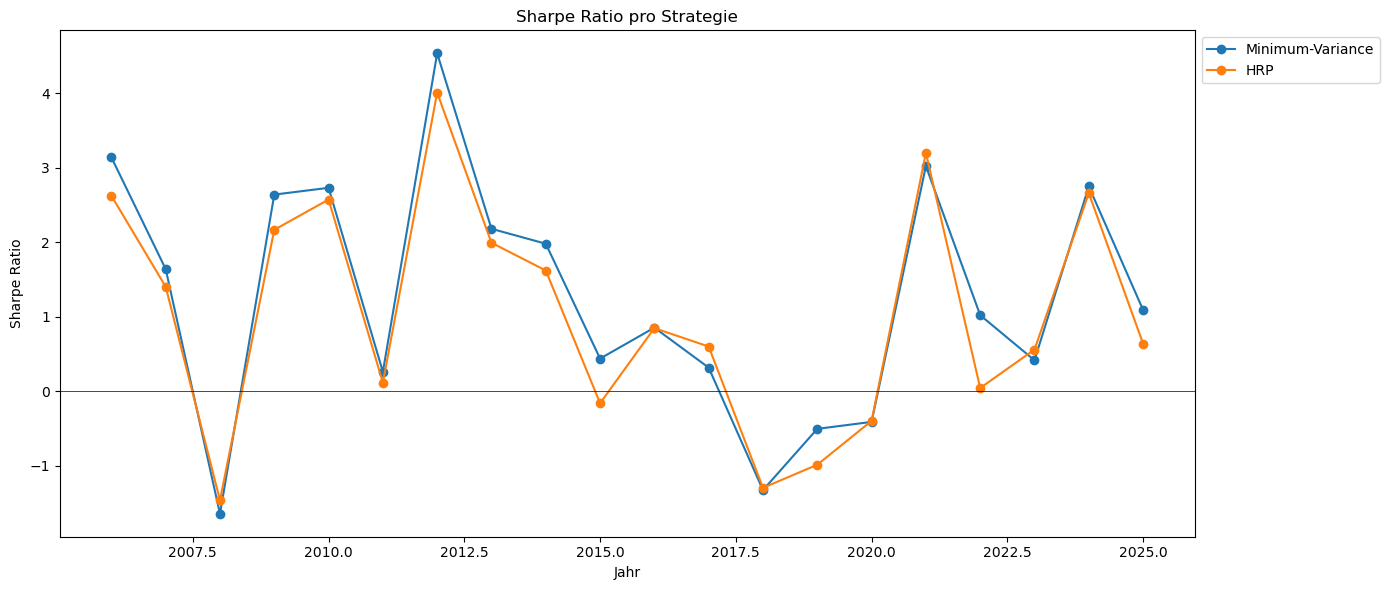

In [103]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [104]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.644102
Minimum-Variance           0.833196
Maximum-Diversification    0.861743
Inverse-Volatility         0.625695
Equal-Risk-Contribution    0.700493
HRP                        0.658147
HERC                       0.419879
dtype: float64


In [105]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.064016          4.621723                 3.720687   
2007          1.254721          2.267451                 2.386958   
2008         -1.336816         -2.104135                -2.429779   
2009          2.638123          4.208953                 3.754328   
2010          2.729618          4.099438                 3.938540   
2011         -0.016143          0.347691                 0.224674   
2012          3.823565          8.517809                 6.464555   
2013          1.367001          3.173877                 2.670084   
2014          1.812769          2.900460                 2.200783   
2015         -0.830521          0.596752                 0.277220   
2016          2.198295          1.194256                 1.946306   
2017          1.313013          0.444365                 0.221052   
2018         -1.149650         -1.746925                -1.495799   
2019         -0.433581         -0.619558                -0.720334   
2020          0.079617         -0.505997                 0.081338   
2021          5.017061          4.727950                 6.375704   
2022         -0.022092          1.428843                 1.876365   
2023          0.761789          0.594078                 0.573182   
2024          2.997002          4.504798                 4.802318   
2025          1.087534          1.576601                 2.390899   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.184063                 3.345691  3.693147  2.320353  
2007            1.293272                 1.608659  1.934901  0.127180  
2008           -1.327840                -1.568418 -1.887748 -0.681708  
2009            2.607764                 2.936718  3.296381  0.331539  
2010            3.031014                 3.459587  3.862111  1.329273  
2011            0.023836                 0.133899  0.157648  1.008339  
2012            4.531467                 5.206928  6.776518  3.655465  
2013            1.691213                 1.818277  2.803657  0.894953  
2014            2.092529                 2.029238  2.364842  2.256110  
2015           -0.616838                -0.503086 -0.204075  0.193347  
2016            1.699868                 1.844195  1.157648  0.984830  
2017            1.348999                 0.981381  0.889603  1.147123  
2018           -1.267291                -1.248593 -1.717709 -0.631197  
2019           -0.558929                -0.471471 -1.274715 -0.057611  
2020           -0.123399                -0.080156 -0.499118 -0.093132  
2021            4.571462                 5.166673  4.944457  1.851451  
2022           -0.071149                 0.172094  0.062646  0.535979  
2023            0.825359                 0.893569  0.813227 -0.204637  
2024            3.029950                 3.731020  4.567573  2.874186  
2025            0.822032                 1.297378  0.874672  1.279353

In [106]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.893591
Minimum-Variance           1.126519
Maximum-Diversification    1.175875
Inverse-Volatility         0.865560
Equal-Risk-Contribution    0.961461
HRP                        0.889065
HERC                       0.592311
dtype: float64


In [107]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.092458                -0.103207   
2007         -0.159674         -0.159545                -0.158158   
2008         -0.377122         -0.384859                -0.408515   
2009         -0.190988         -0.120114                -0.118960   
2010         -0.075705         -0.044339                -0.040888   
2011         -0.125871         -0.107014                -0.111270   
2012         -0.040825         -0.025512                -0.028156   
2013         -0.074547         -0.072418                -0.061882   
2014         -0.080819         -0.052544                -0.059570   
2015         -0.230653         -0.128637                -0.121568   
2016         -0.083576         -0.077467                -0.068970   
2017         -0.100200         -0.078913                -0.092936   
2018         -0.136383         -0.133461                -0.125337   
2019         -0.123416         -0.115953                -0.125999   
2020         -0.429823         -0.392957                -0.409672   
2021         -0.052836         -0.033910                -0.032442   
2022         -0.129398         -0.066782                -0.064418   
2023         -0.107711         -0.083006                -0.088881   
2024         -0.048191         -0.035055                -0.040317   
2025         -0.099655         -0.066825                -0.057860   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.108789                -0.107745 -0.103605 -0.112598  
2007           -0.155442                -0.158533 -0.143079 -0.149491  
2008           -0.371467                -0.385294 -0.396437 -0.445094  
2009           -0.194794                -0.166816 -0.169711 -0.150765  
2010           -0.070034                -0.058126 -0.053763 -0.110541  
2011           -0.118973                -0.112553 -0.105863 -0.091150  
2012           -0.035694                -0.030606 -0.025254 -0.034014  
2013           -0.074817                -0.067580 -0.070270 -0.093369  
2014           -0.076155                -0.071139 -0.062801 -0.086106  
2015           -0.219042                -0.193303 -0.179074 -0.164696  
2016           -0.093798                -0.083095 -0.105216 -0.096725  
2017           -0.089702                -0.077466 -0.070439 -0.090429  
2018           -0.144451                -0.127438 -0.138346 -0.182073  
2019           -0.126142                -0.106074 -0.140722 -0.175832  
2020           -0.424880                -0.415705 -0.425079 -0.377051  
2021           -0.051946                -0.048013 -0.043016 -0.099293  
2022           -0.126705                -0.116221 -0.101349 -0.212061  
2023           -0.104135                -0.093232 -0.089589 -0.197877  
2024           -0.044387                -0.043325 -0.035162 -0.064300  
2025           -0.106218                -0.090119 -0.095827 -0.079923

In [108]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.507104
Minimum-Variance          -0.503618
Maximum-Diversification   -0.520107
Inverse-Volatility        -0.512915
Equal-Risk-Contribution   -0.489224
HRP                       -0.536277
HERC                      -0.459151
dtype: float64>

In [109]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.270410          3.060051                 2.325230   
2007          0.777797          1.316666                 1.542612   
2008         -0.649906         -0.728524                -0.793725   
2009          1.794685          2.944342                 2.946535   
2010          3.121171          4.979403                 5.400861   
2011         -0.070445          0.162577                 0.096030   
2012          5.570770         12.054817                 9.036286   
2013          1.517990          2.676561                 2.742090   
2014          1.412138          2.600021                 1.841602   
2015         -0.405626          0.316943                 0.127486   
2016          2.694828          1.043713                 2.005206   
2017          0.681742          0.230974                 0.092467   
2018         -0.691639         -0.838417                -0.793512   
2019         -0.257316         -0.391851                -0.417853   
2020         -0.060478         -0.319089                -0.043851   
2021          8.027979          8.476247                12.181385   
2022         -0.087409          1.549736                 2.214244   
2023          0.454546          0.352672                 0.349290   
2024          3.799022          5.820337                 5.845977   
2025          0.446663          0.703520                 1.287628   

      Inverse-Volatility  Equal-Risk-Contribution        HRP      HERC  
Date                                                                    
2006            2.360251                 2.382139   2.571073  1.807302  
2007            0.801523                 0.982071   1.236415  0.011708  
2008           -0.639930                -0.672161  -0.725707 -0.461272  
2009            1.622186                 1.917872   1.878287  0.167290  
2010            3.538463                 4.185516   4.427550  1.222368  
2011           -0.040790                 0.044999   0.062600  1.020792  
2012            7.102499                 8.230608  10.973259  7.238509  
2013            1.869258                 2.045128   2.807267  0.845303  
2014            1.718437                 1.583241   1.971757  2.222280  
2015           -0.336857                -0.274291  -0.144866  0.057200  
2016            1.802048                 1.845610   0.911492  1.079958  
2017            0.767004                 0.566045   0.526130  0.796827  
2018           -0.722952                -0.704083  -0.831646 -0.455552  
2019           -0.322804                -0.285130  -0.554534 -0.103883  
2020           -0.163870                -0.132069  -0.321748 -0.182577  
2021            7.215800                 7.723148   7.858468  2.138793  
2022           -0.126551                 0.069415  -0.013865  0.276466  
2023            0.505767                 0.553066   0.478493 -0.146237  
2024            4.040263                 4.558699   6.157166  3.924386  
2025            0.300525                 0.546621   0.313390  0.642014

In [110]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           7.749048
Minimum-Variance           8.373647
Maximum-Diversification    9.669028
Inverse-Volatility         6.941257
Equal-Risk-Contribution    7.945867
HRP                        5.746271
HERC                       4.812427
dtype: float64>

In [111]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.010814                -0.011728   
2007         -0.014825         -0.011674                -0.013462   
2008         -0.026470         -0.023444                -0.023031   
2009         -0.017581         -0.010629                -0.011444   
2010         -0.011813         -0.007092                -0.007460   
2011         -0.012912         -0.008182                -0.008489   
2012         -0.008335         -0.004696                -0.005495   
2013         -0.012646         -0.008586                -0.009162   
2014         -0.008447         -0.006261                -0.006561   
2015         -0.015140         -0.008095                -0.009183   
2016         -0.013721         -0.010064                -0.010538   
2017         -0.007297         -0.005978                -0.006638   
2018         -0.010606         -0.008668                -0.009018   
2019         -0.008850         -0.007725                -0.008101   
2020         -0.024322         -0.017705                -0.019045   
2021         -0.009399         -0.007476                -0.007464   
2022         -0.014066         -0.009620                -0.010289   
2023         -0.010136         -0.008022                -0.008404   
2024         -0.008724         -0.006283                -0.006422   
2025         -0.010363         -0.009969                -0.007713   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.020220                -0.018301 -0.016056 -0.021203  
2007           -0.014841                -0.014475 -0.013704 -0.019340  
2008           -0.026377                -0.025627 -0.025723 -0.036666  
2009           -0.017302                -0.015314 -0.013545 -0.024762  
2010           -0.010080                -0.009313 -0.008224 -0.014349  
2011           -0.012592                -0.011020 -0.008987 -0.013615  
2012           -0.008435                -0.006966 -0.005537 -0.009502  
2013           -0.012661                -0.011362 -0.009912 -0.013984  
2014           -0.008703                -0.007352 -0.006855 -0.012040  
2015           -0.014006                -0.012402 -0.011724 -0.016591  
2016           -0.014336                -0.012381 -0.012053 -0.014178  
2017           -0.007441                -0.006830 -0.006324 -0.009299  
2018           -0.011256                -0.009845 -0.009291 -0.016503  
2019           -0.009529                -0.008265 -0.008045 -0.014741  
2020           -0.025050                -0.021279 -0.021660 -0.032913  
2021           -0.009167                -0.008333 -0.007938 -0.015346  
2022           -0.013600                -0.012693 -0.011839 -0.020355  
2023           -0.010270                -0.009225 -0.007989 -0.014019  
2024           -0.008415                -0.006739 -0.006409 -0.012291  
2025           -0.010303                -0.009801 -0.009168 -0.012050

In [112]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.013134
Minimum-Variance          -0.009436
Maximum-Diversification   -0.009939
Inverse-Volatility        -0.012994
Equal-Risk-Contribution   -0.011497
HRP                       -0.010725
HERC                      -0.017478
dtype: float64>

In [113]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.042664
Minimum-Variance          -0.043669
Maximum-Diversification   -0.043473
Inverse-Volatility        -0.043287
Equal-Risk-Contribution   -0.041163
HRP                       -0.043952
HERC                      -0.065002
dtype: float64>

In [114]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028949         -0.021300                -0.023019   
2007         -0.021062         -0.019090                -0.020599   
2008         -0.035045         -0.030131                -0.030176   
2009         -0.022245         -0.014105                -0.016289   
2010         -0.015736         -0.010253                -0.010425   
2011         -0.017402         -0.011309                -0.012171   
2012         -0.011270         -0.006433                -0.006989   
2013         -0.016928         -0.011700                -0.012443   
2014         -0.012386         -0.009066                -0.009232   
2015         -0.020828         -0.014751                -0.014130   
2016         -0.019512         -0.014151                -0.014162   
2017         -0.009765         -0.009183                -0.009641   
2018         -0.013804         -0.012706                -0.012464   
2019         -0.012207         -0.013086                -0.012912   
2020         -0.051343         -0.042972                -0.044015   
2021         -0.013765         -0.010983                -0.010460   
2022         -0.019328         -0.014462                -0.014999   
2023         -0.012535         -0.009988                -0.011062   
2024         -0.011932         -0.008548                -0.009255   
2025         -0.023034         -0.017287                -0.016993   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.028439                -0.027225 -0.025880 -0.031534  
2007           -0.020453                -0.020333 -0.018854 -0.024973  
2008           -0.034144                -0.033035 -0.032427 -0.049361  
2009           -0.020883                -0.018163 -0.016499 -0.029020  
2010           -0.014668                -0.012617 -0.011272 -0.019792  
2011           -0.016763                -0.014997 -0.012438 -0.019256  
2012           -0.010448                -0.008911 -0.007324 -0.012370  
2013           -0.016537                -0.015159 -0.013542 -0.019152  
2014           -0.012177                -0.010829 -0.010196 -0.015405  
2015           -0.021387                -0.018469 -0.018565 -0.026156  
2016           -0.019728                -0.016842 -0.017780 -0.022484  
2017           -0.009694                -0.008622 -0.008110 -0.012484  
2018           -0.014035                -0.012504 -0.012687 -0.020506  
2019           -0.012623                -0.011250 -0.011978 -0.020008  
2020           -0.050852                -0.048611 -0.047505 -0.052761  
2021           -0.013683                -0.012067 -0.011711 -0.020554  
2022           -0.019452                -0.017735 -0.017310 -0.027592  
2023           -0.012379                -0.010937 -0.010075 -0.017995  
2024           -0.011470                -0.010185 -0.008810 -0.015900  
2025           -0.022966                -0.021297 -0.020338 -0.022412

In [115]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.021519
Minimum-Variance          -0.016488
Maximum-Diversification   -0.017282
Inverse-Volatility        -0.021107
Equal-Risk-Contribution   -0.019470
HRP                       -0.018631
HERC                      -0.026731
dtype: float64>

In [116]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.092950
Minimum-Variance          -0.086193
Maximum-Diversification   -0.091247
Inverse-Volatility        -0.091934
Equal-Risk-Contribution   -0.090798
HRP                       -0.093598
HERC                      -0.096227
dtype: float64>

In [117]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.245094
Minimum-Variance          -0.280379
Maximum-Diversification   -0.324248
Inverse-Volatility        -0.237713
Equal-Risk-Contribution   -0.258979
HRP                       -0.287697
HERC                      -0.205310
dtype: float64>

In [118]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.644102  0.893591     -0.507104  7.749048 -0.042664   
Minimum-Variance         0.833196  1.126519     -0.503618  8.373647 -0.043669   
Maximum-Diversification  0.861743  1.175875     -0.520107  9.669028 -0.043473   
Inverse-Volatility       0.625695  0.865560     -0.512915  6.941257 -0.043287   
Equal-Risk-Contribution  0.700493  0.961461     -0.489224  7.945867 -0.041163   
HRP                      0.658147  0.889065     -0.536277  5.746271 -0.043952   
HERC                     0.419879  0.592311     -0.459151  4.812427 -0.065002   

                             ES_M  
Equally-Weighted        -0.092950  
Minimum-Variance        -0.086193  
Maximum-Diversification -0.091247  
Inverse-Volatility      -0.091934  
Equal-Risk-Contribution -0.090798  
HRP                     -0.093598  
HERC                    -0.096227  


## S&P500 3 Jahre